In [1]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import time
import pandas as pd
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [2]:
EPSILON = 10e-10
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    #chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    raw_mel = librosa.feature.melspectrogram(X, sr=sample_rate).T
    mel = np.mean(raw_mel, axis=0)
    processed_mel = raw_mel + EPSILON
    logMel = np.mean(np.log(processed_mel),axis=0)
    #contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    #tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,logMel, mel

def parse_audio_files(parent_dir,sub_dirs,file_ext='*.wav'):
    features, labels, namePath = np.empty((0,168)), np.empty(0), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            mfccs, logmel, mel = extract_feature(fn)
            ext_features = np.hstack([mfccs,logmel])
            features = np.vstack([features,ext_features])
            labels = np.append(labels, fn.split('/')[2].split('-')[1])
            namePath = np.append(namePath, fn)
    return np.array(features), np.array(labels, dtype = np.int), np.array(namePath, dtype=np.string_)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

def one_hot_decode(labels):
    n_labels, n_unique_labels = np.shape(labels)
    one_hot_decode = np.zeros((n_labels))
    for idx in range(n_labels):
        for l in range(n_unique_labels):
            if(labels[idx, l] == 1):
                one_hot_decode[idx] = l
                break;
    return one_hot_decode

In [3]:
x = extract_feature("audio/fold1/7061-6-0-0.wav")
nfMfccs = np.shape(x[0])[0]
nfLogMel = np.shape(x[1])[0]
nfMel = np.shape(x[2])[0]

In [4]:
print "Number of features"
print "* Mfcc: {0}".format(nfMfccs)
print "* logMel {0}".format(nfLogMel)
print "* Mel {0}".format(nfMel)

Number of features
* Mfcc: 40
* logMel 128
* Mel 128


In [5]:
features = np.load("nn_features_fold_full.npy", allow_pickle=True)
labels = np.load("nn_labels_fold_full.npy", allow_pickle=True)
file_names = np.load("nn_file_names_fold_full.npy", allow_pickle=True)

In [9]:
np.shape(features)

(8732, 168)

In [7]:
mfccs_col = ["mfcc_" + str(i) for i in range(nfMfccs)]
logMel_col = ["logMel_" + str(i) for i in range(nfLogMel)]
mel_col = ["mel_" + str(i) for i in range(nfMel)]

In [10]:
features_df = pd.DataFrame(data=features, columns=mfccs_col+logMel_col)

In [11]:
features_df.describe()

mfcc_0       mfcc_1       mfcc_2       mfcc_3       mfcc_4  \
count  8732.000000  8732.000000  8732.000000  8732.000000  8732.000000   
mean   -223.166115   106.835343   -20.491447    13.395726    -6.145359   
std     133.595348    49.749483    32.119678    21.221388    15.774188   
min    -761.138985   -77.527587  -164.931456   -79.702016   -95.826082   
25%    -308.918379    78.003886   -37.169836     2.327530   -15.573155   
50%    -211.387696   112.516571   -16.661059    14.780229    -5.178177   
75%    -123.493878   140.262682    -1.023994    26.851878     4.631793   
max     201.331057   268.518726    95.784267   103.942254    54.859100   

            mfcc_5       mfcc_6       mfcc_7       mfcc_8       mfcc_9  \
count  8732.000000  8732.000000  8732.000000  8732.000000  8732.000000   
mean      7.809932    -1.382840     5.321050    -3.606627     3.905746   
std      13.951013    12.938978    10.635542     9.995901     8.051969   
min     -59.564081   -61.012919   -41.257288   -50.305639   -65.947799   
25%       0.058619    -8.642495    -1.000497    -9.467168    -1.071807   
50%       8.779962    -0.775645     5.539024    -3.156672     4.460988   
75%      16.400727     6.857501    11.905134     2.794303     9.111697   
max      71.835609    54.566474    47.550470    38.832735    50.400969   

          ...        logMel_118   logMel_119   logMel_120   logMel_121  \
count     ...       8732.000000  8732.000000  8732.000000  8732.000000   
mean      ...         -8.468773    -8.556958    -8.656734    -8.747270   
std       ...          3.900557     3.912081     3.916570     3.924877   
min       ...        -20.706078   -20.694471   -20.690137   -20.681061   
25%       ...        -10.838682   -10.939917   -11.020608   -11.131606   
50%       ...         -8.270389    -8.337156    -8.438541    -8.539183   
75%       ...         -5.786037    -5.833311    -6.015278    -6.038388   
max       ...          3.693464     3.548370     3.466746     3.415863   

        logMel_122   logMel_123   logMel_124   logMel_125   logMel_126  \
count  8732.000000  8732.000000  8732.000000  8732.000000  8732.000000   
mean     -8.856530    -8.945288    -9.037381    -9.395124   -10.533141   
std       3.880799     3.873026     3.879972     3.867738     3.813766   
min     -20.690979   -20.690422   -20.686589   -20.684558   -20.678261   
25%     -11.210567   -11.315906   -11.440427   -11.795751   -12.946376   
50%      -8.590774    -8.679741    -8.782315    -9.171184   -10.347257   
75%      -6.098297    -6.269903    -6.403869    -6.841421    -8.001162   
max       3.493716     3.606379     3.605431     3.639448     3.544958   

        logMel_127  
count  8732.000000  
mean    -13.084936  
std       3.687734  
min     -20.689299  
25%     -15.595004  
50%     -13.053258  
75%     -10.612684  
max       5.001201  

[8 rows x 168 columns]

In [12]:
features_df.shape

(8732, 168)

In [13]:
np.max(features_df[mfccs_col].max())

268.51872556044577

In [14]:
np.min(features_df[mfccs_col].min())

-761.13898471996913

In [15]:
np.max(features_df[logMel_col].max())

8.016037402996611

In [16]:
np.min(features_df[logMel_col].min())

-20.706077504681403

In [17]:
features_df[mfccs_col] = features_df[mfccs_col]/100

In [18]:
np.max(features_df[mfccs_col].max())

2.6851872556044576

## Univariate Distributions

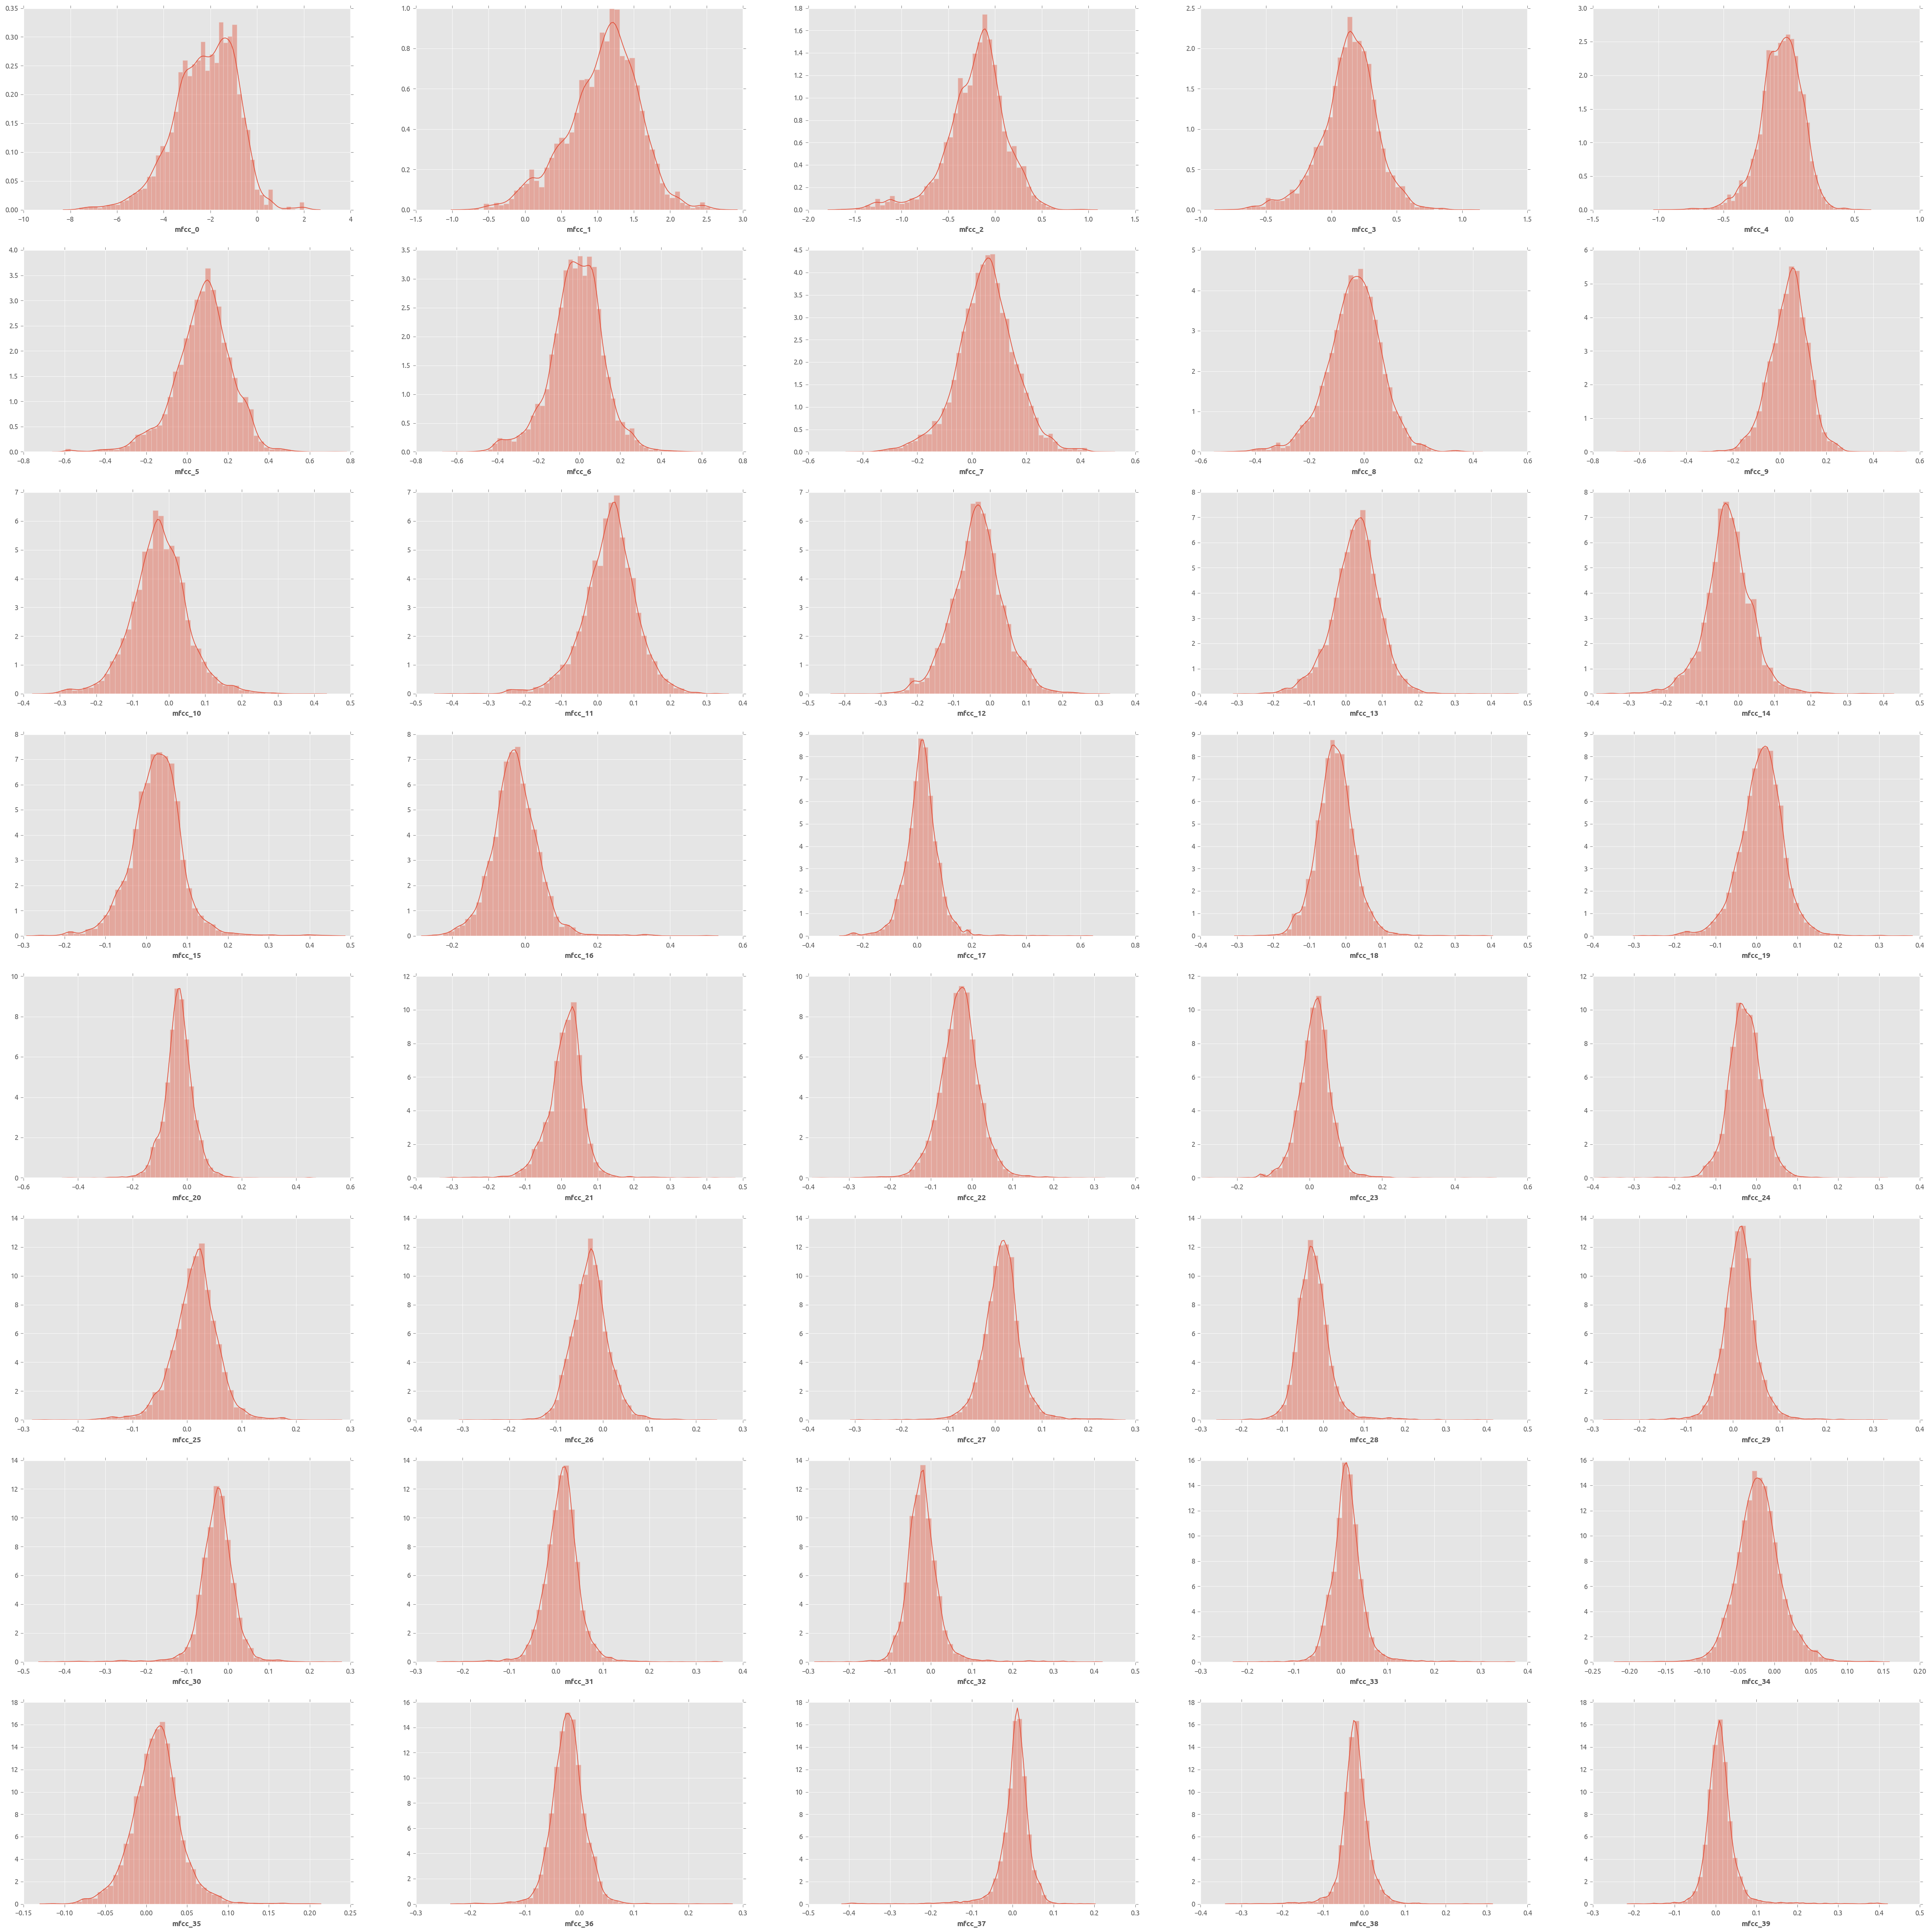

In [19]:
fig = plt.figure(figsize=(50, 50))
for g in range(1,nfMfccs+1):
    ax = fig.add_subplot(8,5,g)
    sns.distplot(features_df["mfcc_" + str(g-1)], ax=ax)

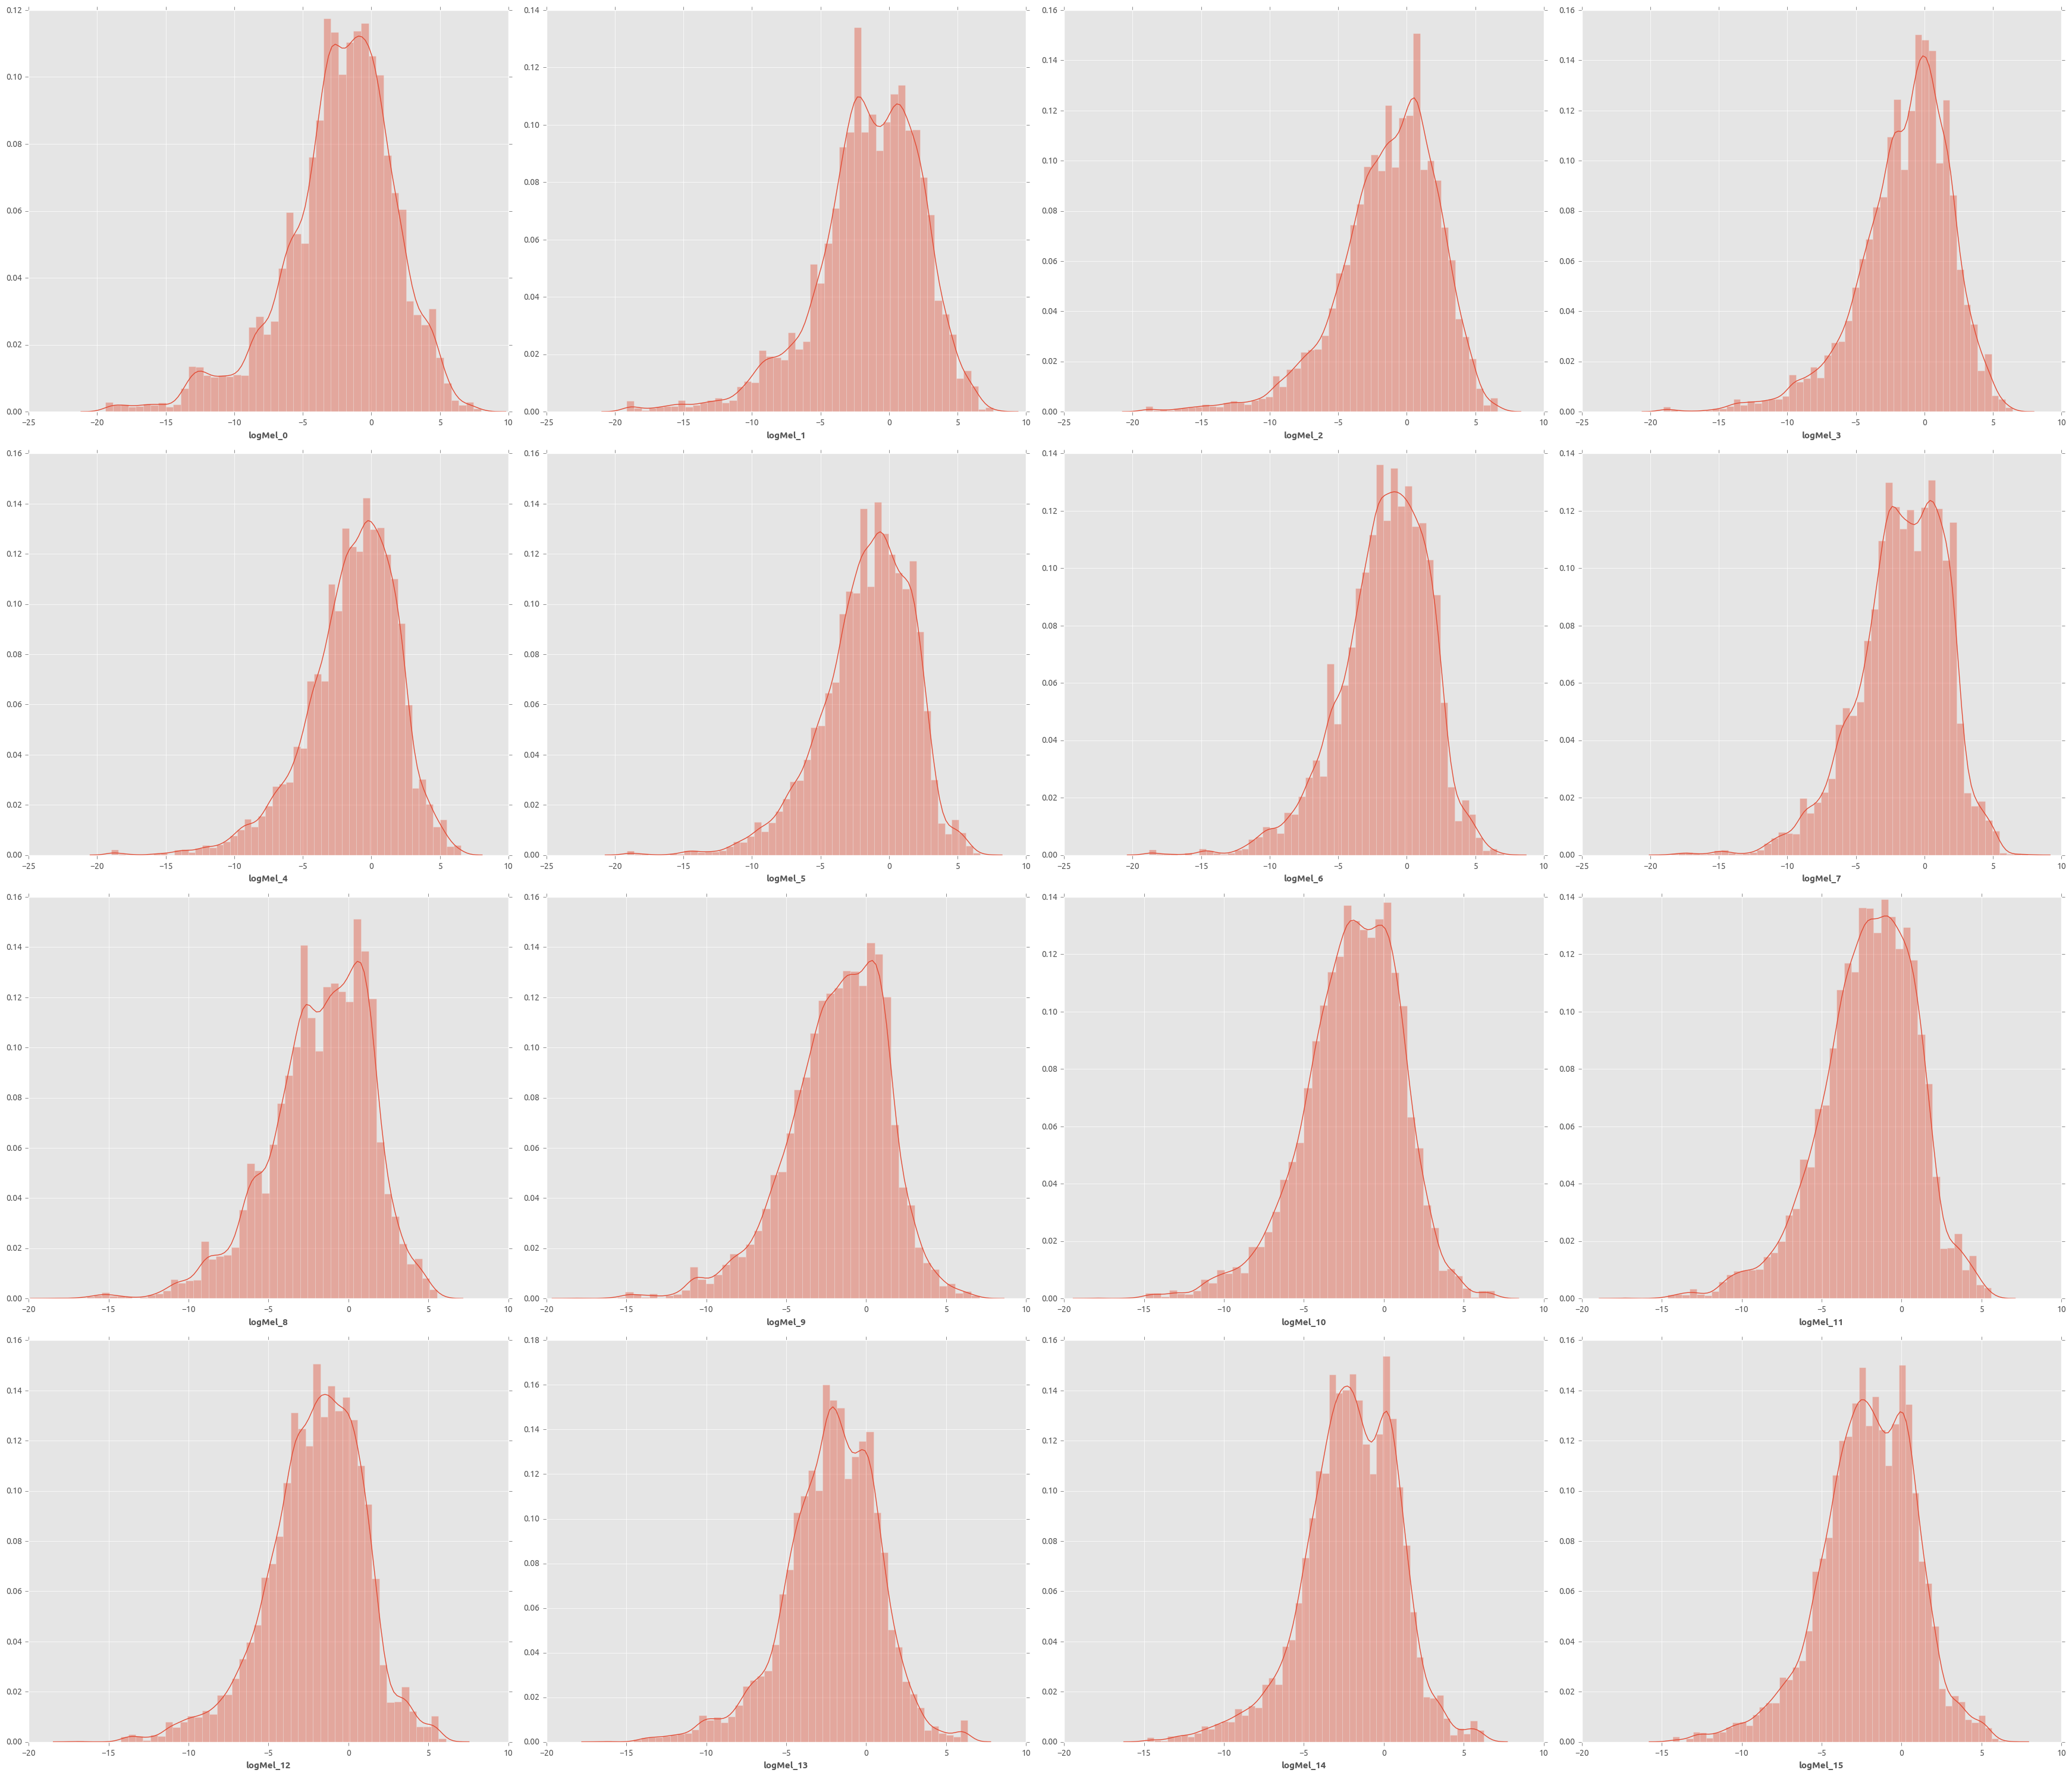

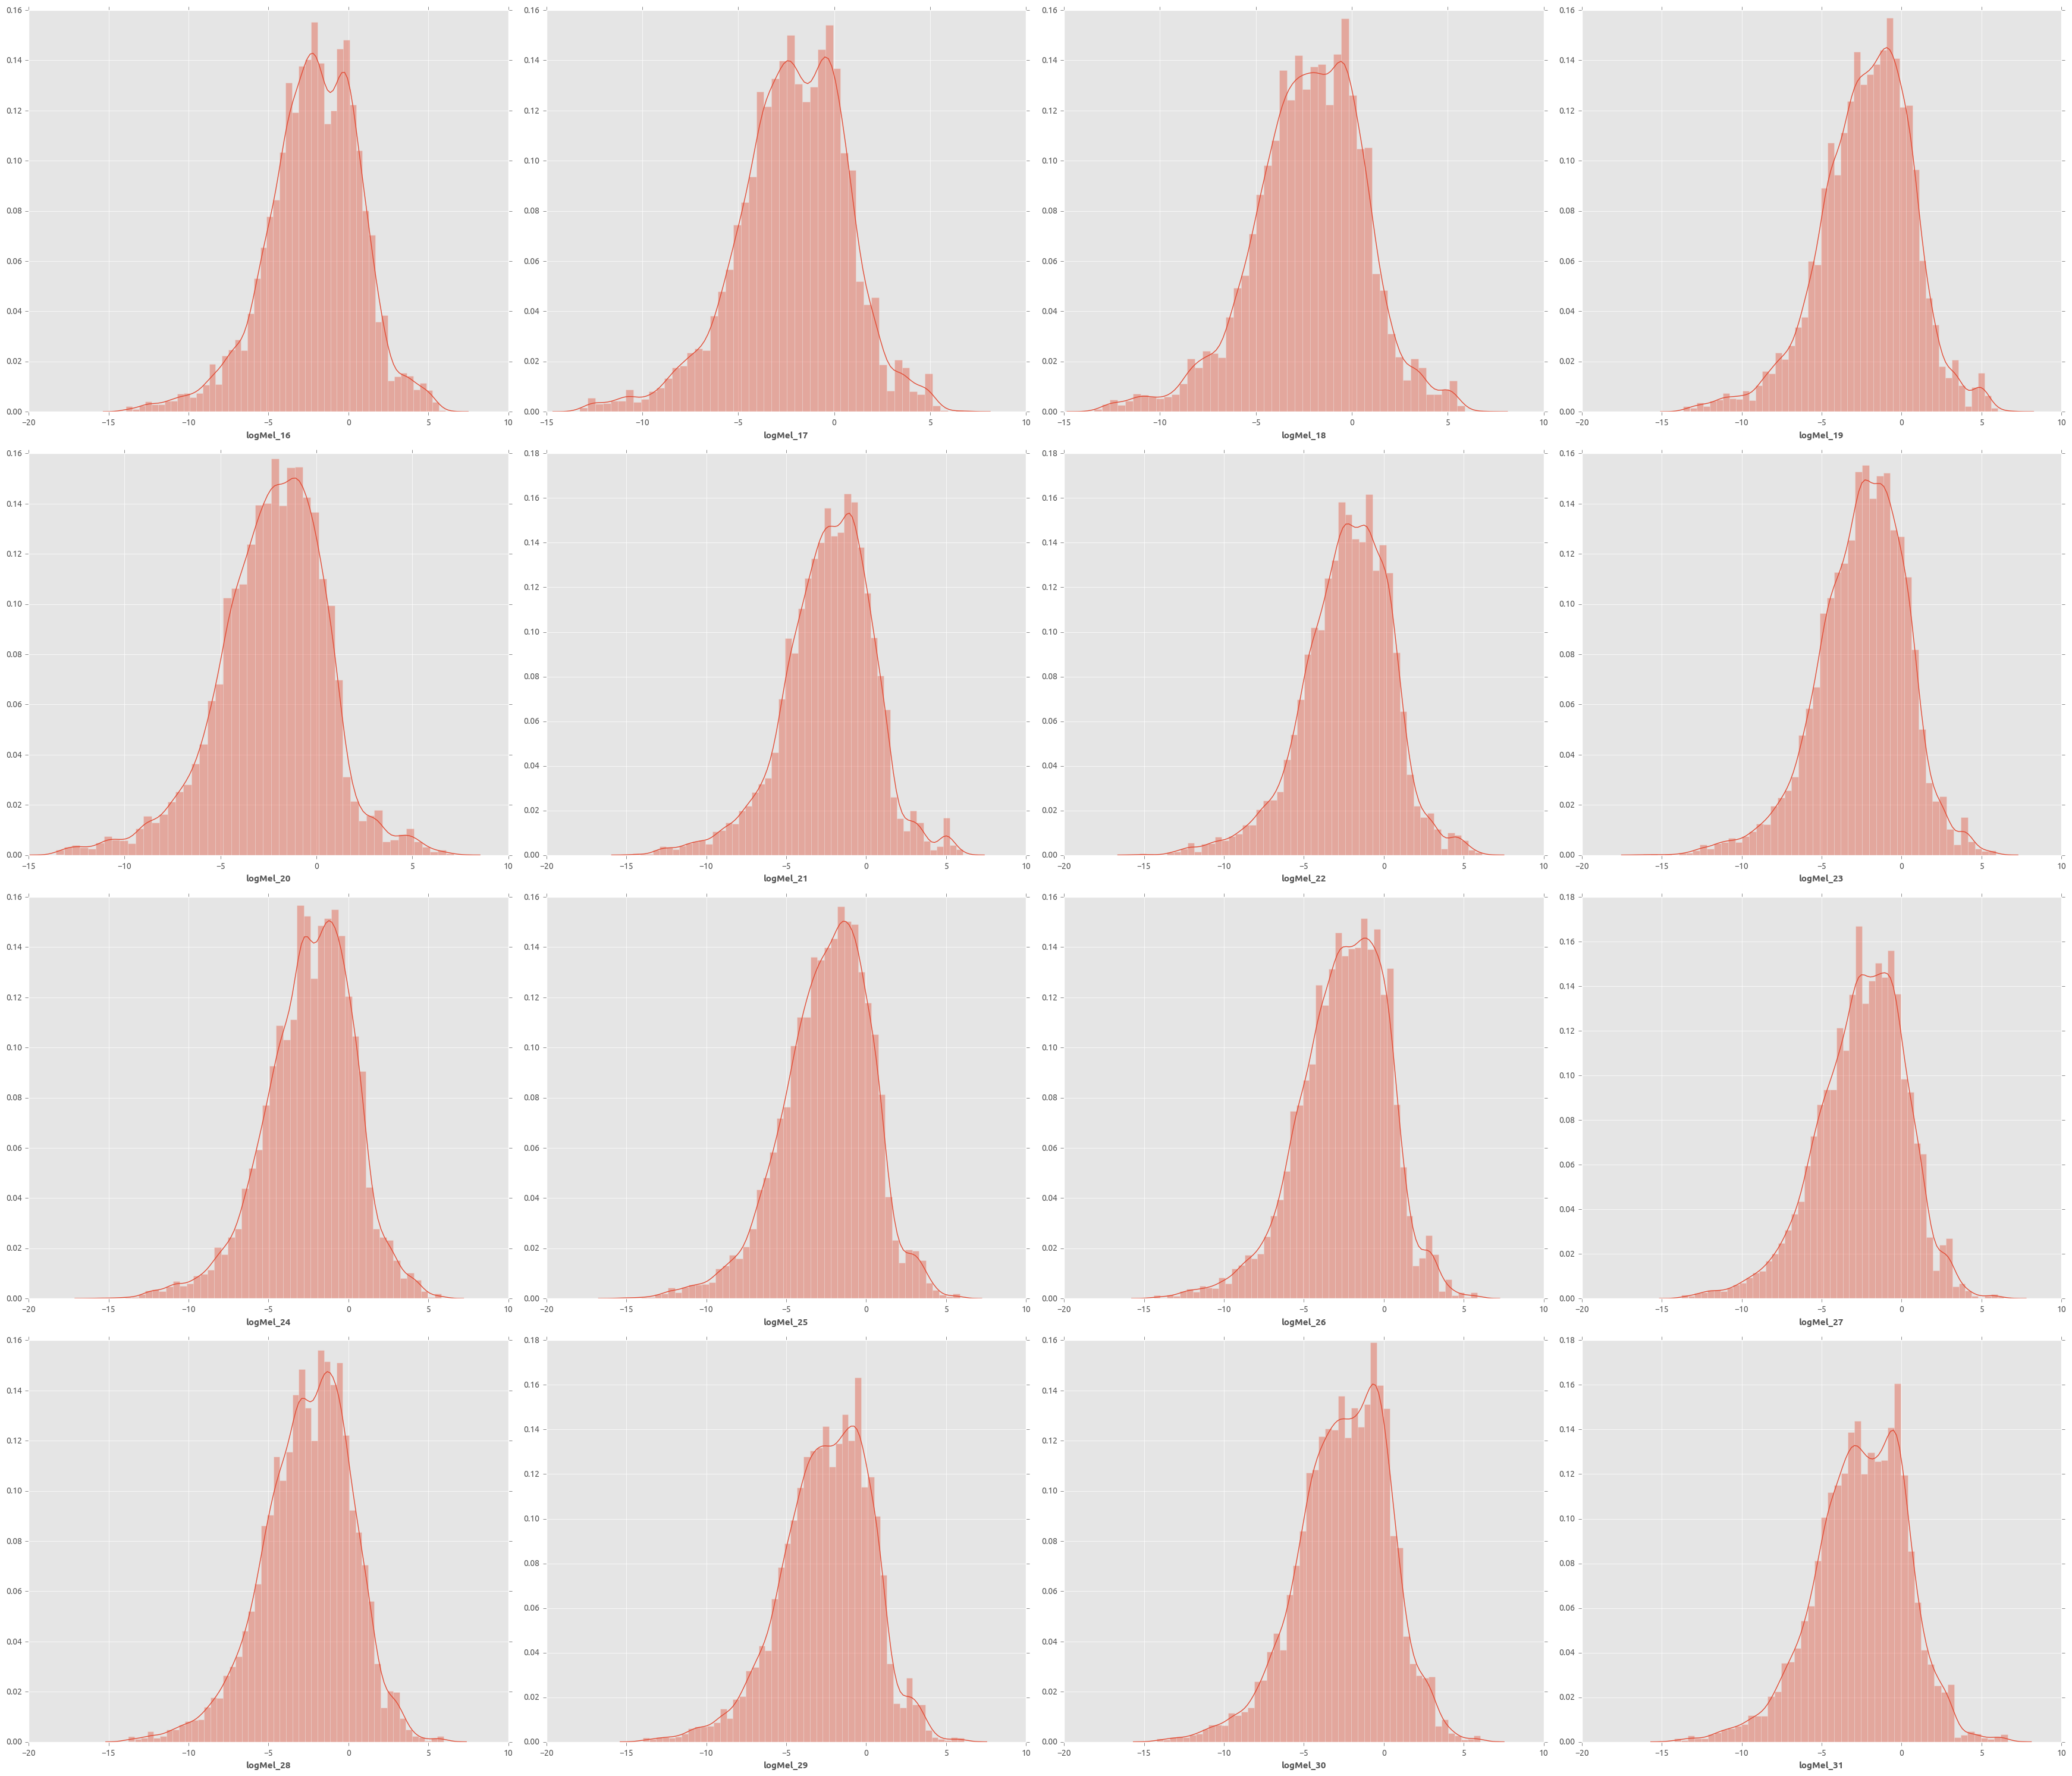

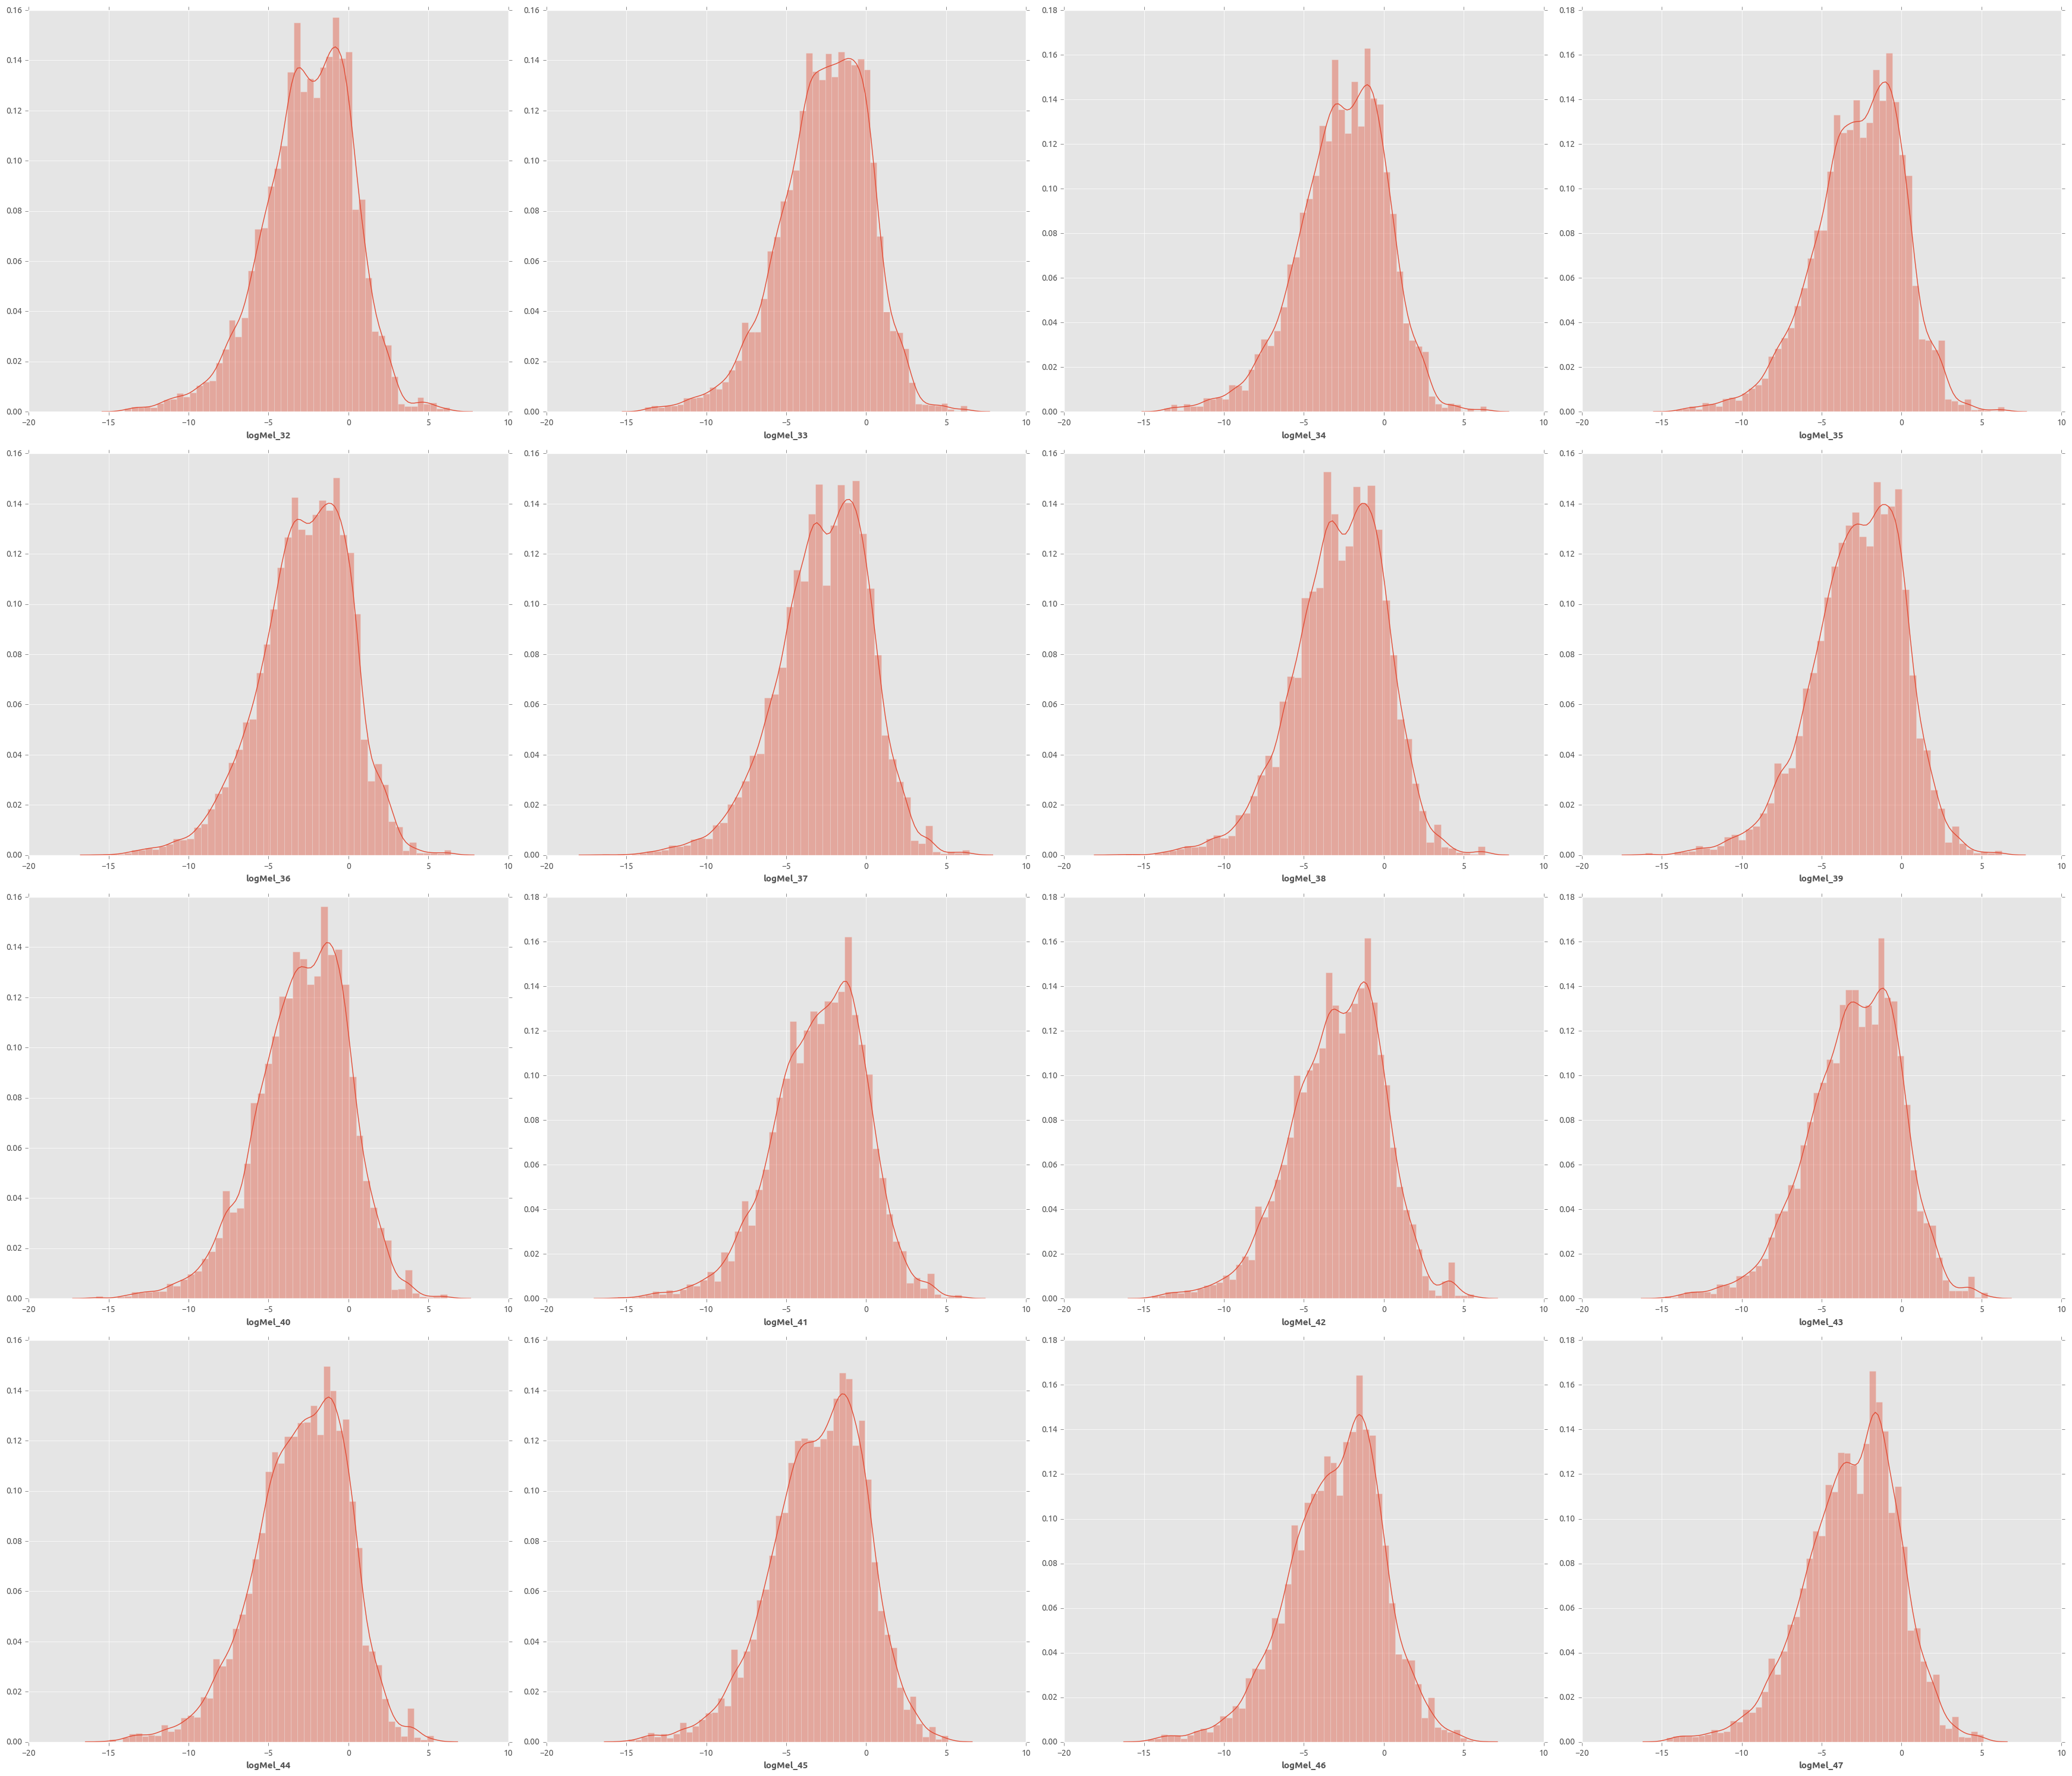

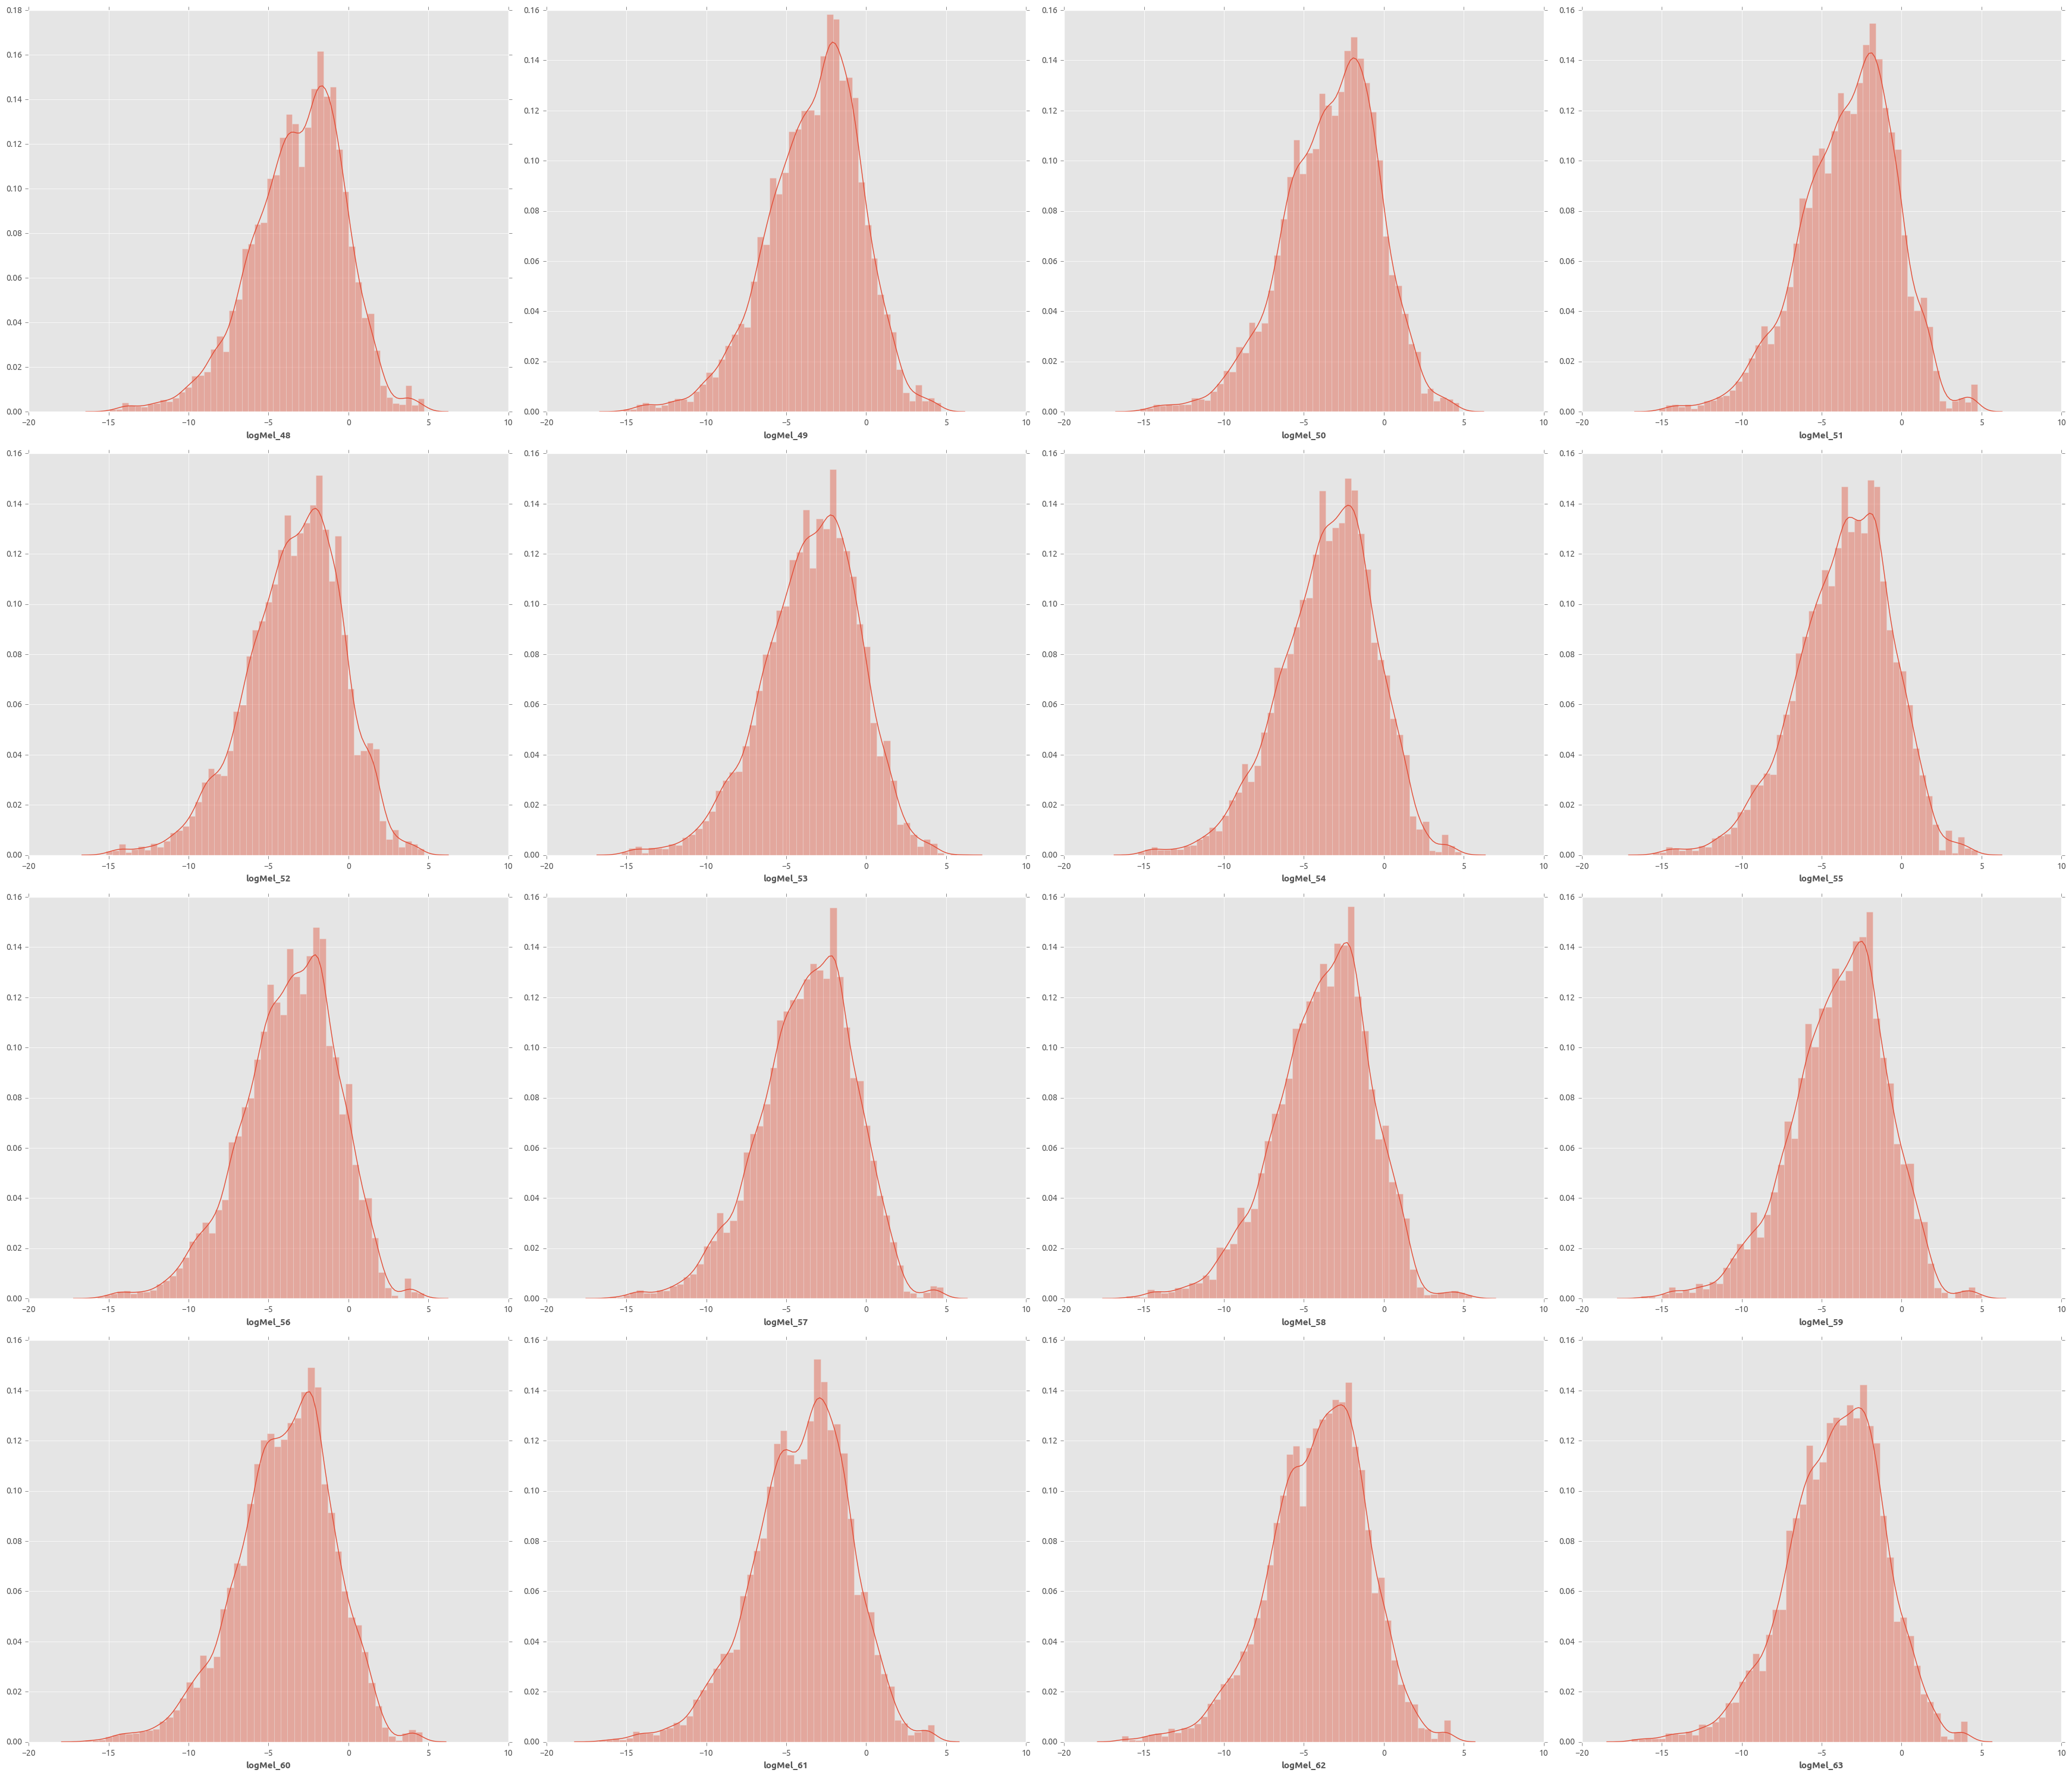

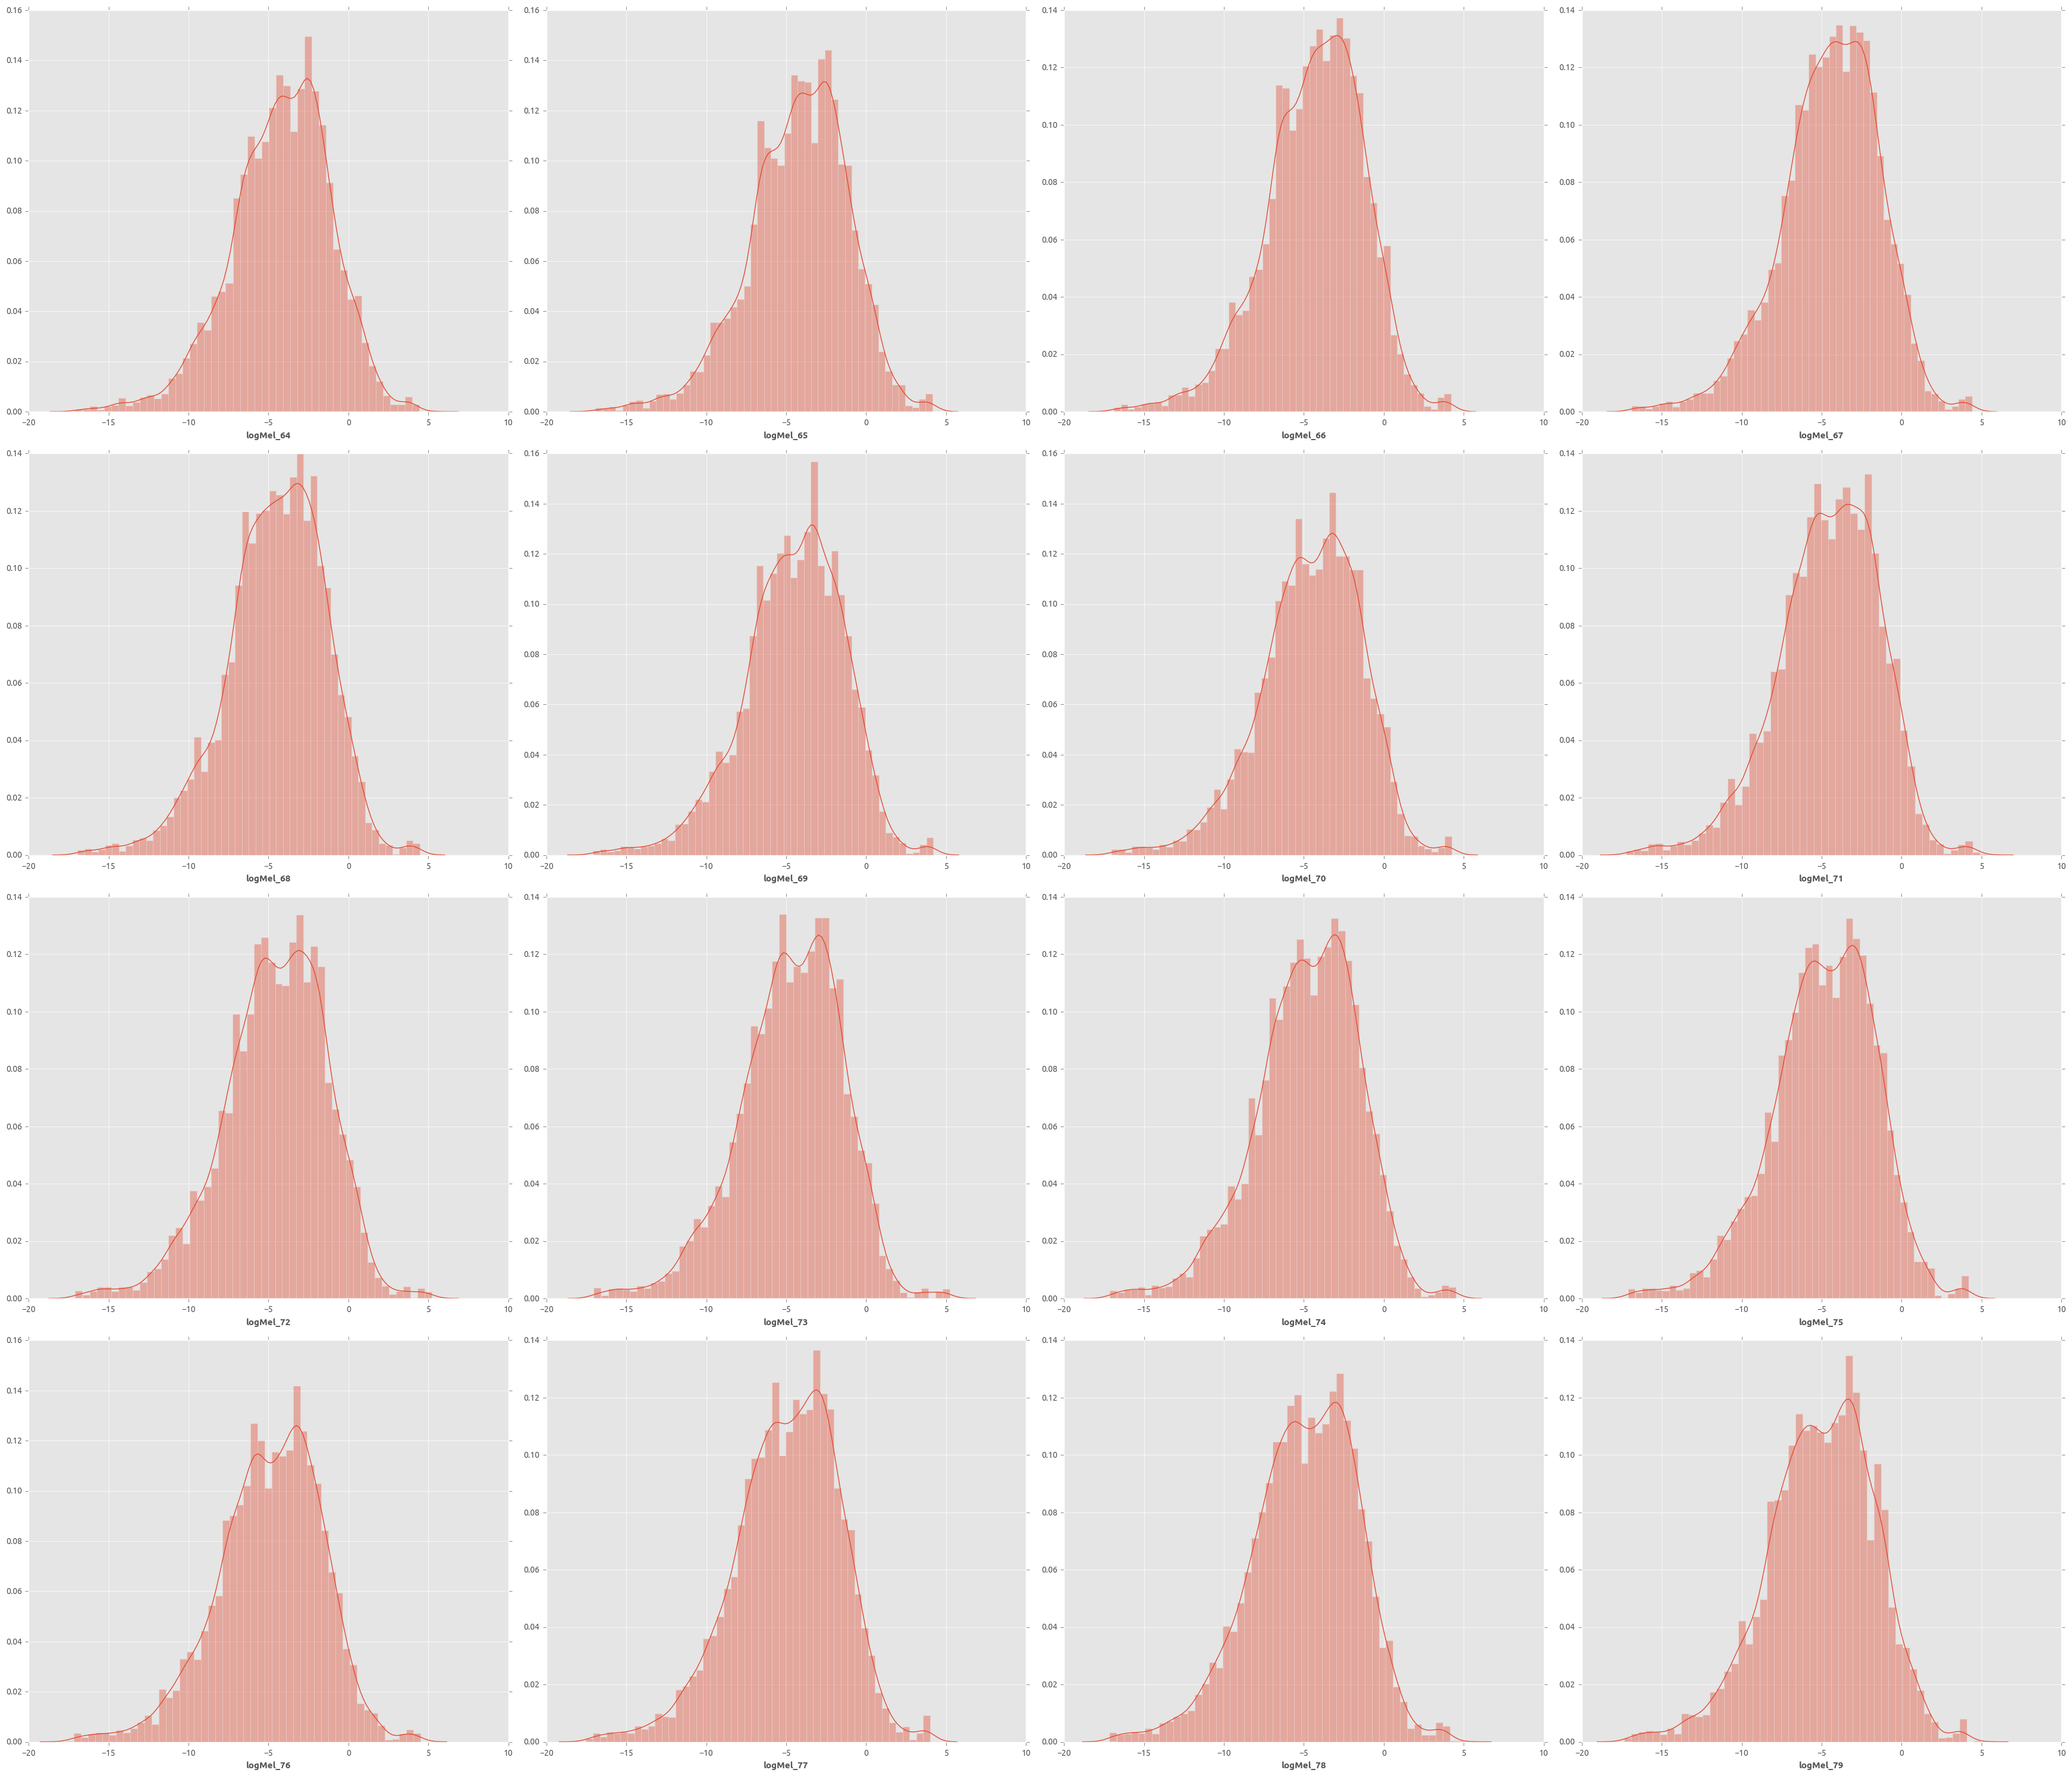

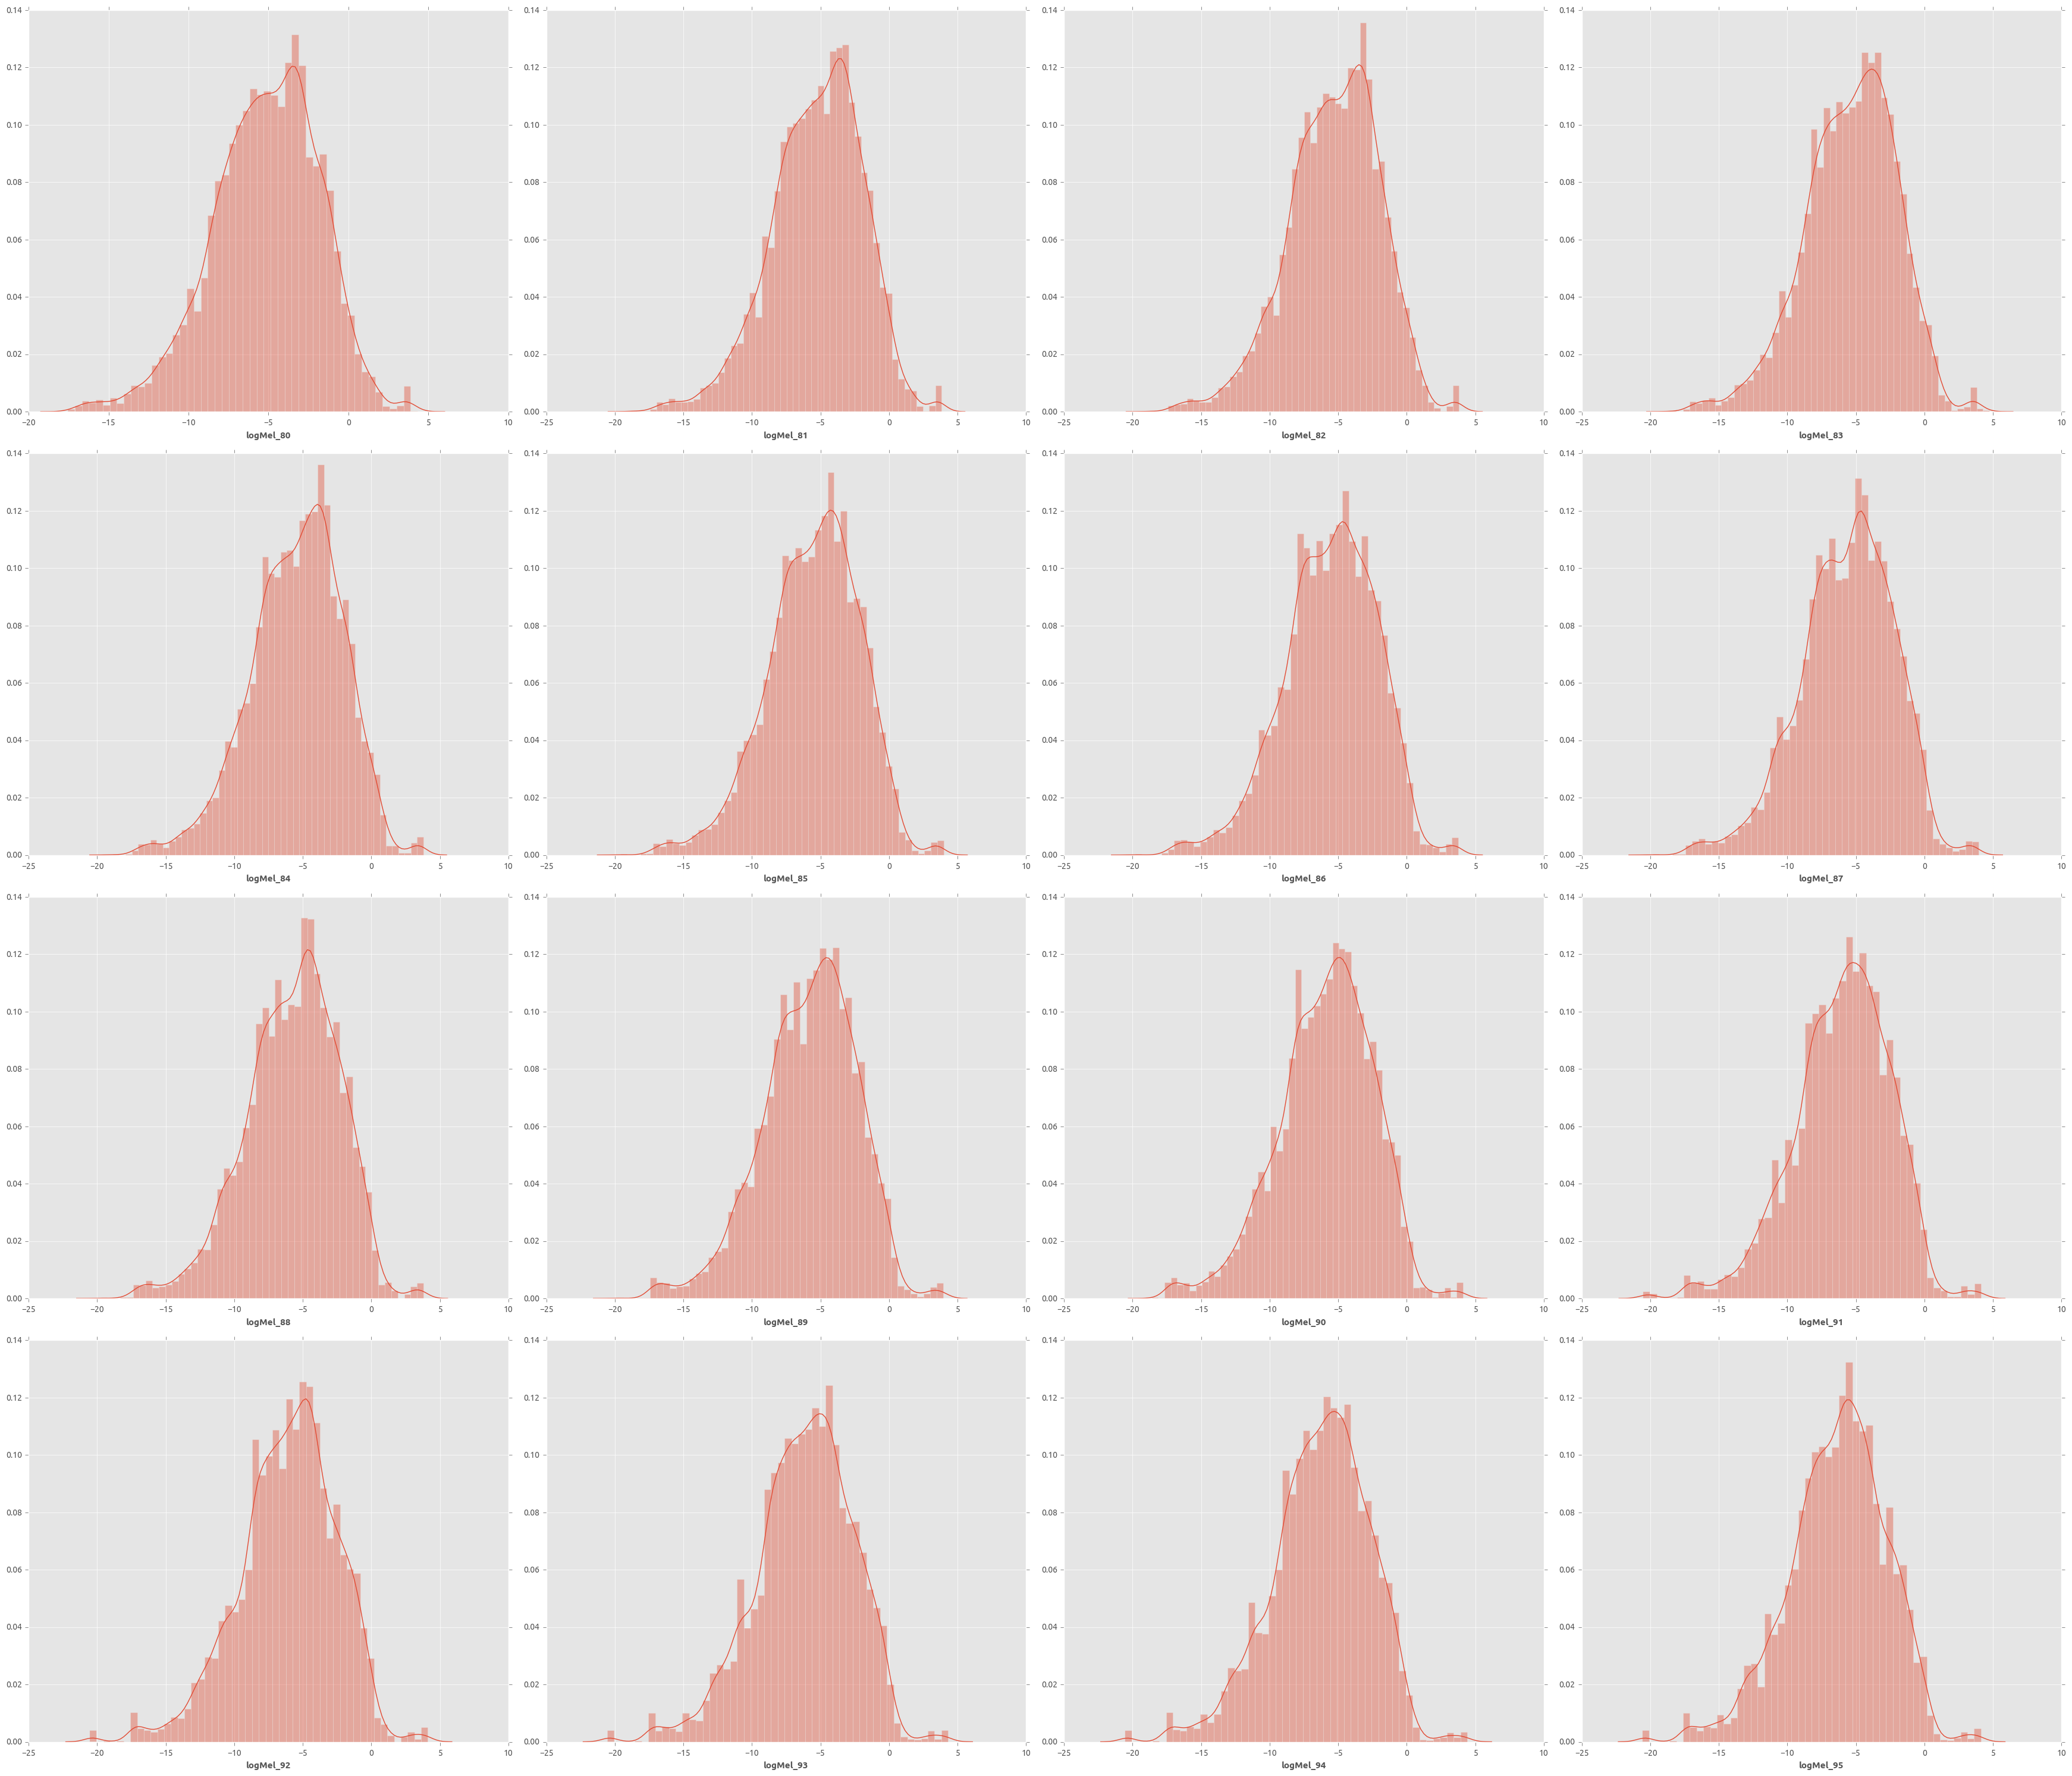

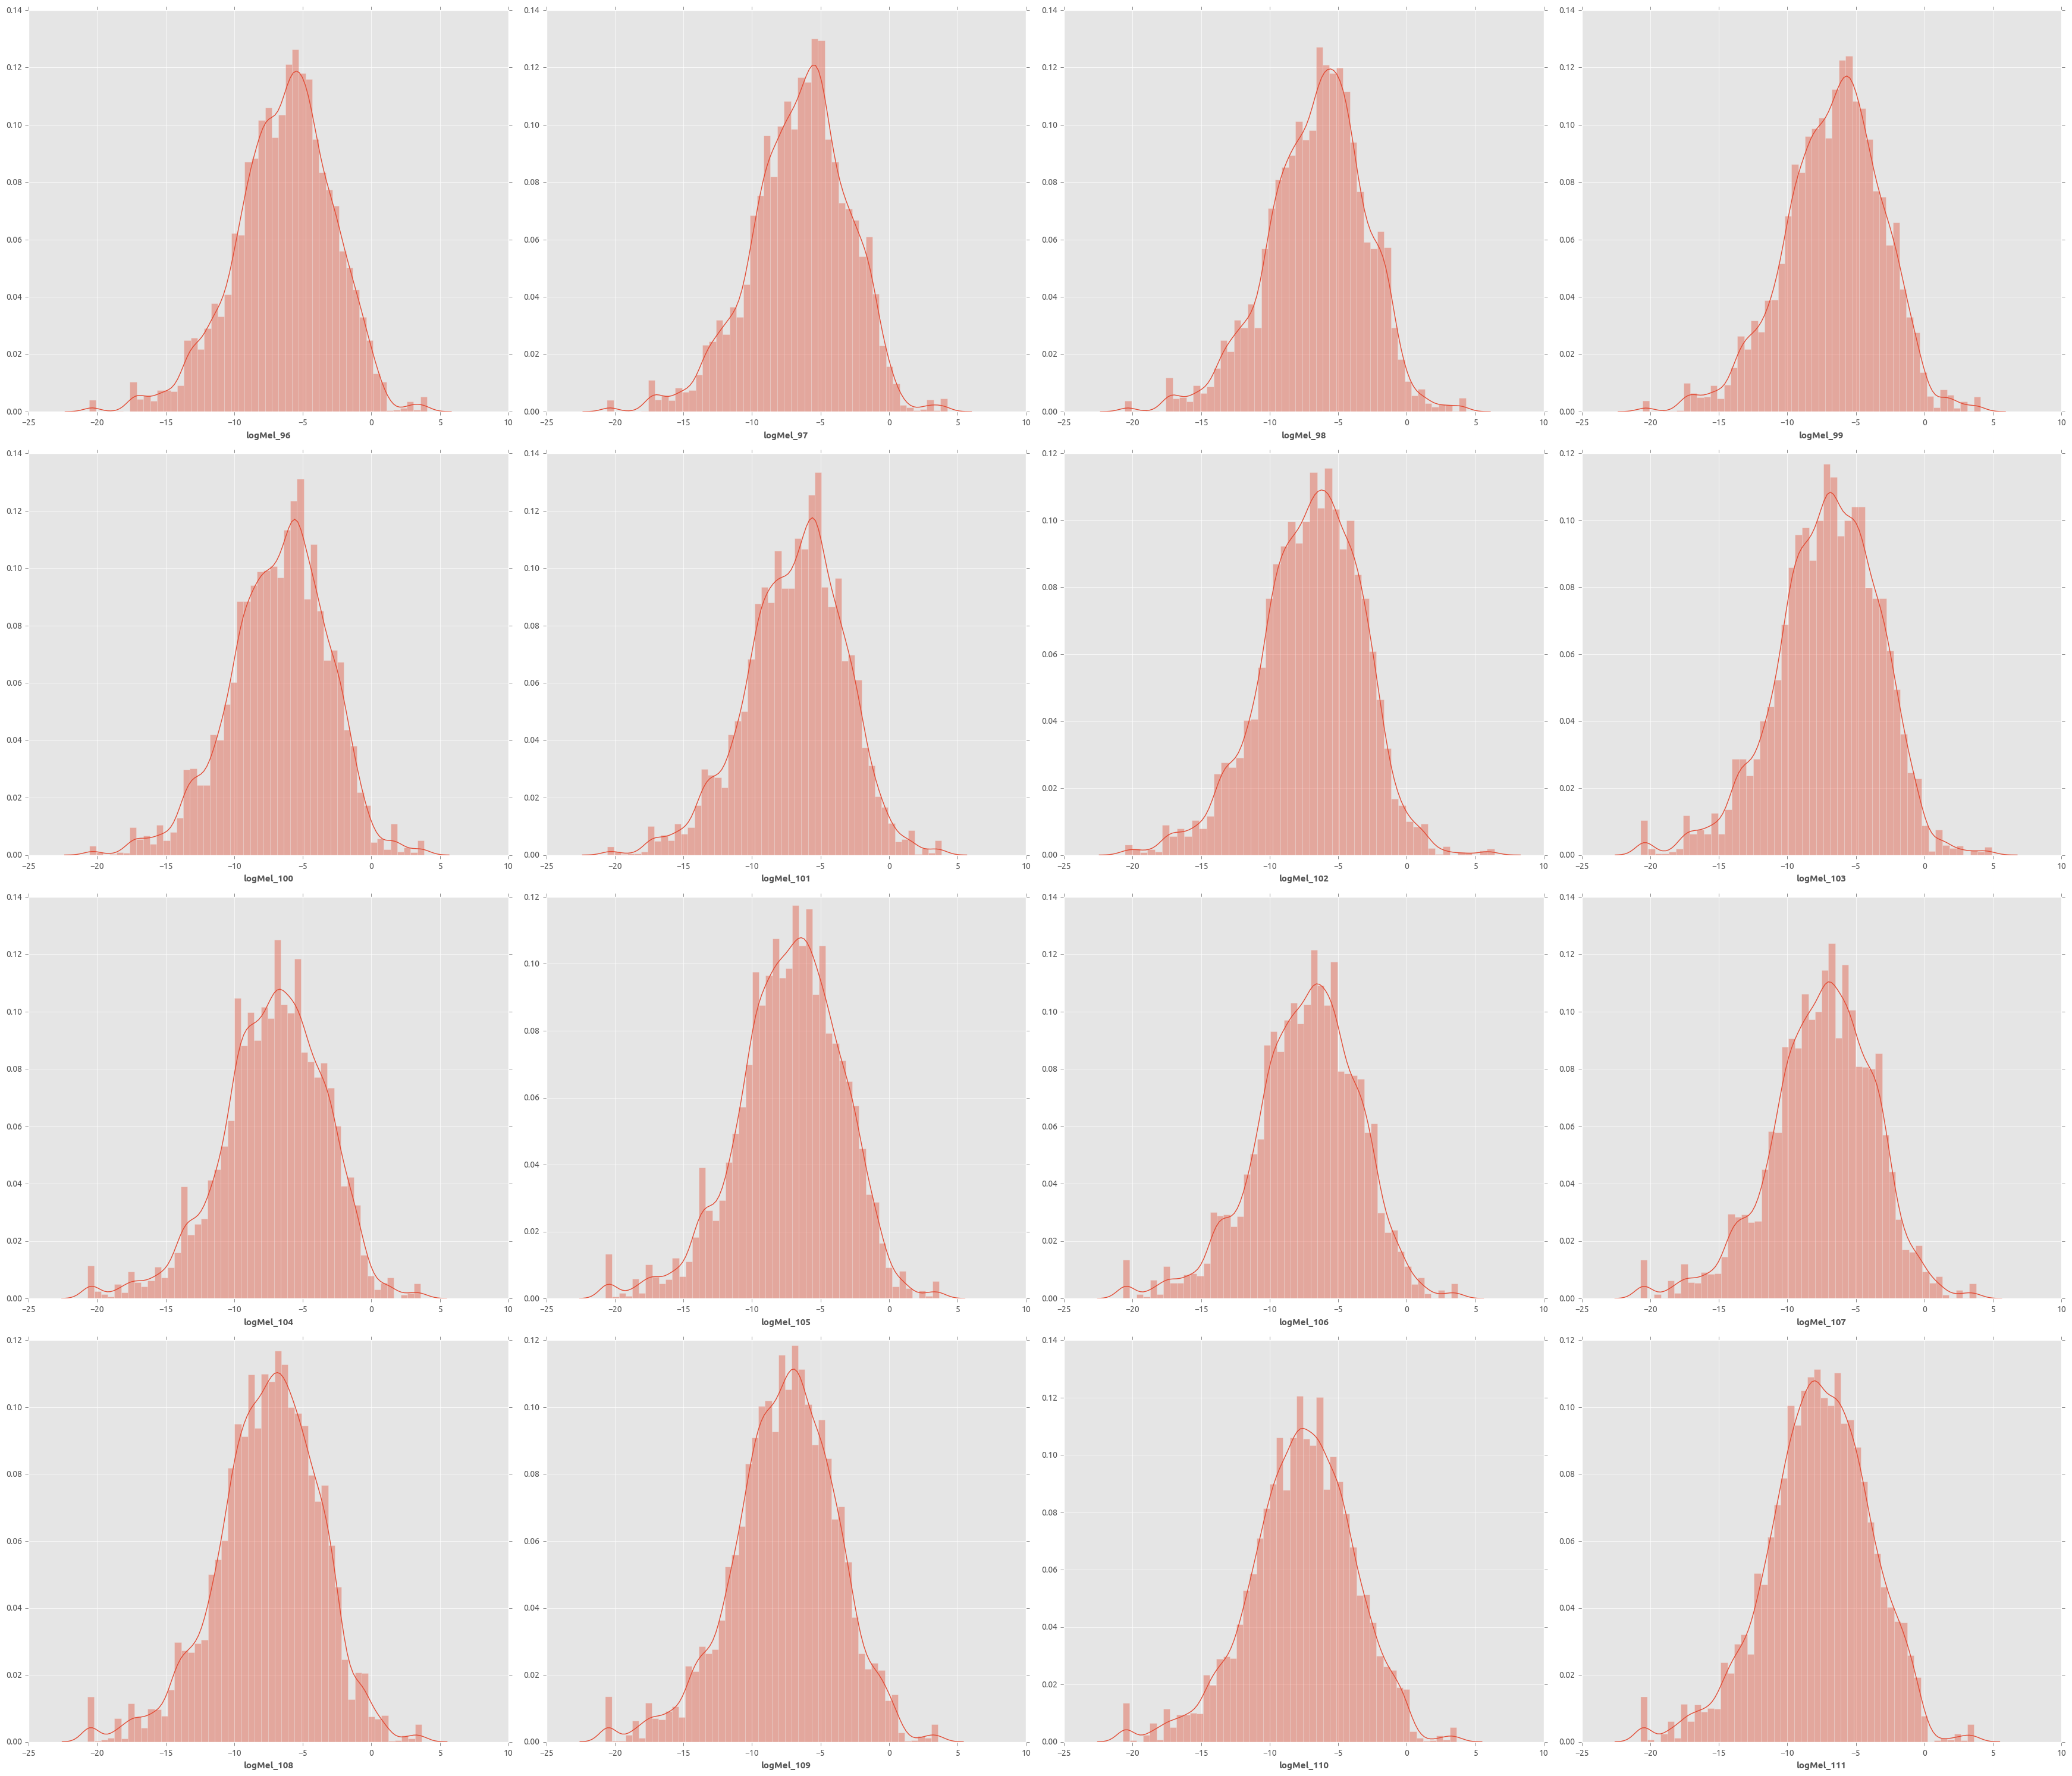

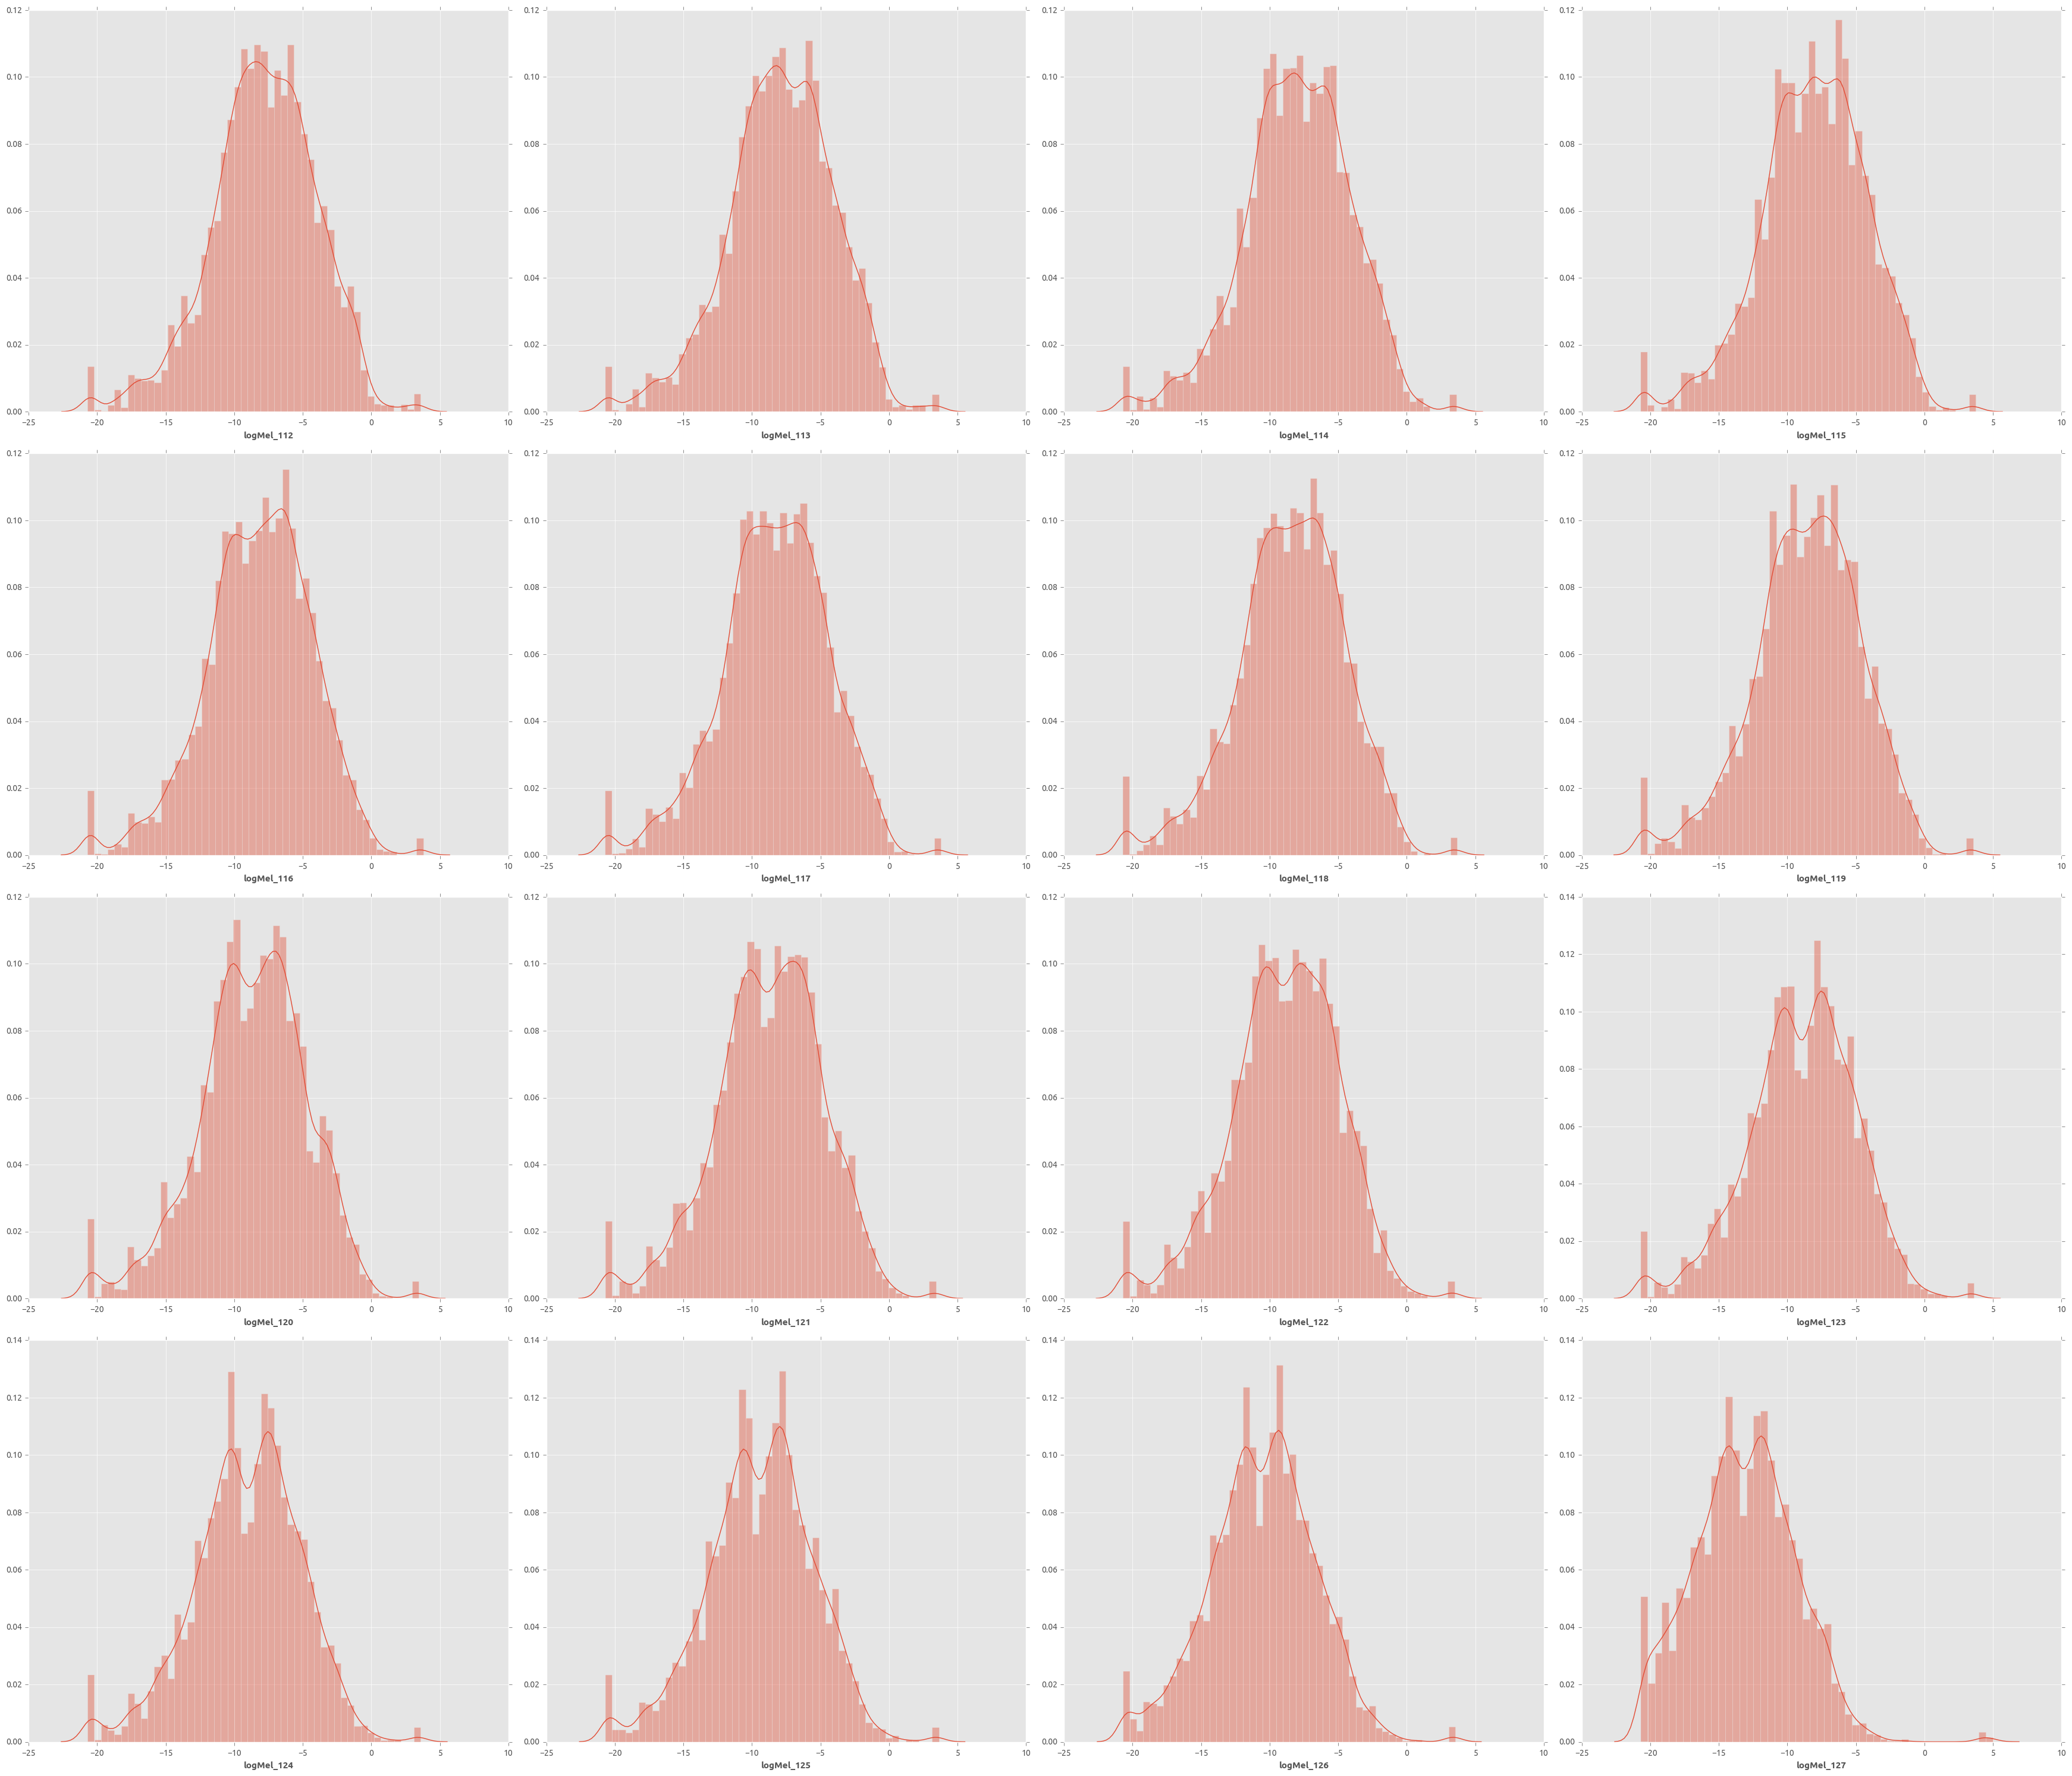

In [21]:
for f in range(8):
    fig = plt.figure(figsize=(35, 30))
    for sp in range(16):
        f_num = f*16+sp
        ax = fig.add_subplot(4,4,sp+1)
        sns.distplot(features_df["logMel_" + str(f_num)], ax=ax)
    fig.tight_layout()

In [22]:
pca_features_df = features_df - features_df.mean()

In [25]:
from sklearn.decomposition import PCA
pca_whitening = PCA(whiten=True)
pca_whitening.fit(pca_features_df)

PCA(copy=True, n_components=None, whiten=True)

In [27]:
pca_whitening_df = pca_whitening.transform(pca_features_df)

In [36]:
xlabels = one_hot_decode(labels)

In [37]:
np.shape(xlabels)

(8732,)

In [46]:
PCA_cols = ["PCA_" + str(i) for i in range(np.shape(pca_features_df)[1])]

In [48]:
pca_whitening_and_labels = np.concatenate((pca_whitening_df, xlabels[:,np.newaxis]), axis=1)
pca_whitening_and_labels_df = pd.DataFrame(data=pca_whitening_and_labels, columns=PCA_cols + ["Label"])

In [49]:
pca_whitening_and_labels_df.head()

PCA_0     PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6  \
0 -1.801507  0.769201 -0.181771  0.056294 -0.671853  0.370269  1.110525   
1  2.475611  0.790323  0.447617  0.239808  0.016721 -0.421144 -0.519569   
2 -0.965402 -0.451872 -0.625539  0.494572 -1.007788  0.735833  0.038545   
3 -0.454600  0.360156  1.605913 -0.411683 -1.232483  0.010455 -0.418280   
4  0.365408  0.088090 -1.112557  1.063141  1.648196 -0.507209 -0.253341   

      PCA_7     PCA_8     PCA_9  ...     PCA_159   PCA_160   PCA_161  \
0  0.489757  0.054363 -0.161652  ...   -0.202050 -0.007996 -0.376466   
1  0.093159 -0.388505  0.265435  ...   -2.158500  2.428133 -3.667977   
2  0.524955 -0.016044 -1.009426  ...    0.110602 -0.120899  0.018026   
3  0.941624 -1.340328  0.422225  ...    0.043101  0.227526  0.111742   
4  0.312019 -0.572210 -0.500363  ...    0.038799  0.213782  0.313056   

    PCA_162   PCA_163   PCA_164   PCA_165   PCA_166   PCA_167  Label  
0  0.167928 -0.471952  0.005909 -0.080277  0.136343  0.098930    7.0  
1  1.960849  1.255465 -1.628294  0.842381 -2.811702 -1.563899    3.0  
2 -0.107652  0.236931 -0.141927  0.110159 -0.193147  0.318352    7.0  
3  0.173545 -0.125180 -0.109589 -0.175056  0.038075 -0.331049    2.0  
4 -0.064282  0.459609 -0.204390 -0.024367 -0.406235 -0.128938    9.0  

[5 rows x 169 columns]

In [53]:
import random

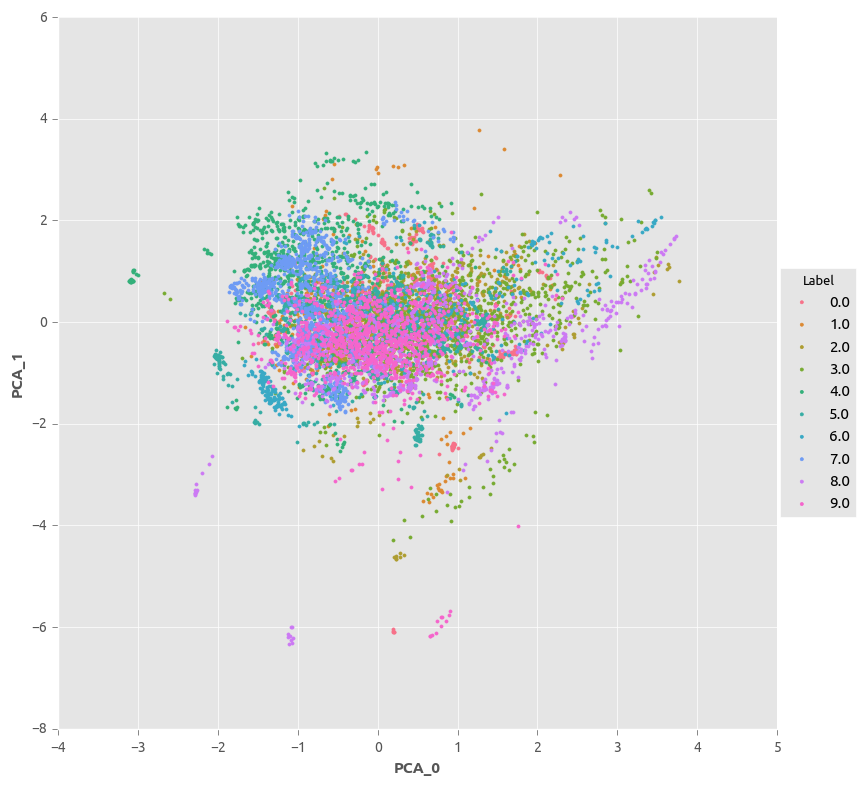

In [55]:
f1 = "PCA_" + str(random.randrange(np.shape(pca_features_df)[1]))
f2 = "PCA_" + str(random.randrange(np.shape(pca_features_df)[1]))
f1 = "PCA_0"
f2 = "PCA_1"
g = sns.FacetGrid(pca_whitening_and_labels_df, hue="Label", size=8)
colors = sns.color_palette("Set2", 10)
g.map(plt.scatter, f1, f2, s=5, cmap=colors)
g.add_legend()

In [56]:
pca = PCA()
pca.fit(pca_features_df)

PCA(copy=True, n_components=None, whiten=False)

In [59]:
pca_df = pca.transform(pca_features_df)

In [60]:
pca_and_labels = np.concatenate((pca_df, xlabels[:,np.newaxis]), axis=1)
pca_and_labels_df = pd.DataFrame(data=pca_and_labels, columns=PCA_cols + ["Label"])
pca_and_labels_df.head()

PCA_0     PCA_1      PCA_2     PCA_3     PCA_4     PCA_5     PCA_6  \
0 -58.290193  9.164591  -1.556152  0.303185 -2.869116  1.312946  3.166937   
1  80.101743  9.416247   3.832070  1.291550  0.071405 -1.493342 -1.481679   
2 -31.236895 -5.383795  -5.355275  2.663647 -4.303710  2.609206  0.109921   
3 -14.709205  4.291050  13.748312 -2.217224 -5.263259  0.037073 -1.192827   
4  11.823255  1.049538  -9.524662  5.725823  7.038543 -1.798522 -0.722465   

      PCA_7     PCA_8     PCA_9  ...     PCA_159   PCA_160   PCA_161  \
0  1.301428  0.127209 -0.363959  ...   -0.000267 -0.000010 -0.000449   
1  0.247552 -0.909101  0.597625  ...   -0.002857  0.003154 -0.004373   
2  1.394960 -0.037542 -2.272720  ...    0.000146 -0.000157  0.000021   
3  2.502169 -3.136363  0.950638  ...    0.000057  0.000296  0.000133   
4  0.829126 -1.338970 -1.126566  ...    0.000051  0.000278  0.000373   

    PCA_162   PCA_163   PCA_164   PCA_165   PCA_166   PCA_167  Label  
0  0.000171 -0.000463  0.000006 -0.000076  0.000122  0.000079    7.0  
1  0.001995  0.001230 -0.001570  0.000792 -0.002515 -0.001245    3.0  
2 -0.000110  0.000232 -0.000137  0.000104 -0.000173  0.000253    7.0  
3  0.000177 -0.000123 -0.000106 -0.000165  0.000034 -0.000264    2.0  
4 -0.000065  0.000450 -0.000197 -0.000023 -0.000363 -0.000103    9.0  

[5 rows x 169 columns]

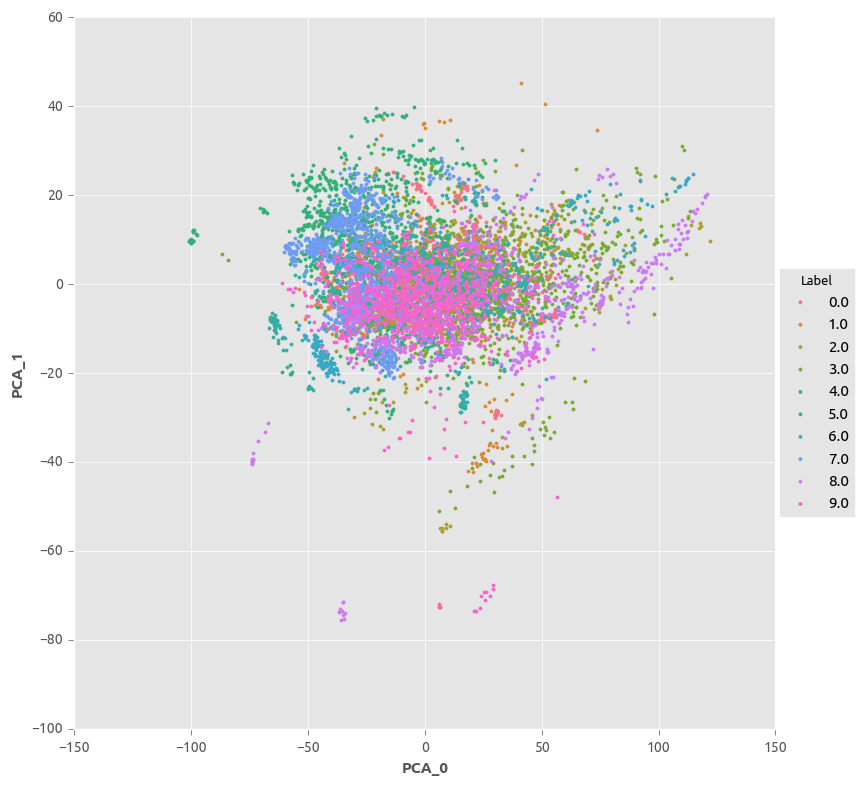

In [61]:
f1 = "PCA_" + str(random.randrange(np.shape(pca_features_df)[1]))
f2 = "PCA_" + str(random.randrange(np.shape(pca_features_df)[1]))
f1 = "PCA_0"
f2 = "PCA_1"
g = sns.FacetGrid(pca_and_labels_df, hue="Label", size=8)
colors = sns.color_palette("Set2", 10)
g.map(plt.scatter, f1, f2, s=5, cmap=colors)
g.add_legend()